# Urban Sound Classification

Martina Corsini and Camilla Gotta

Msc Data science and economics

Università degli studi di Milano

# Set up 

Import necessary libraries

In [1]:
import os
import pathlib
import pickle
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import IPython.display as ipd
from sklearn import metrics
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile as wav

#!pip install librosa
import librosa.display
#!pip install tqdm
from tqdm.notebook import tqdm, trange
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import normalize
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from keras import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import np_utils
from datetime import datetime 
import datetime
from tensorflow import keras

#Set seed for experiment reproducibility
seed = 78
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data Preprocessing

### Explore the UrbanSound dataset 

For this project we will use a dataset called Urbansound8K. The dataset contains 8732 sound excerpts (<=4s) of urban sounds from 10 classes, which are:

- Air Conditioner
- Car Horn
- Children Playing
- Dog bark
- Drilling
- Engine Idling
- Gun Shot
- Jackhammer
- Siren
- 
Street Music

The accompanying metadata contains a unique ID for each sound excerpt along with it's given class name

In [3]:
metadata = pd.read_csv('C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv',sep=',')
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [4]:
print(metadata['class'].value_counts())

street_music        1000
dog_bark            1000
engine_idling       1000
jackhammer          1000
children_playing    1000
drilling            1000
air_conditioner     1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64


C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


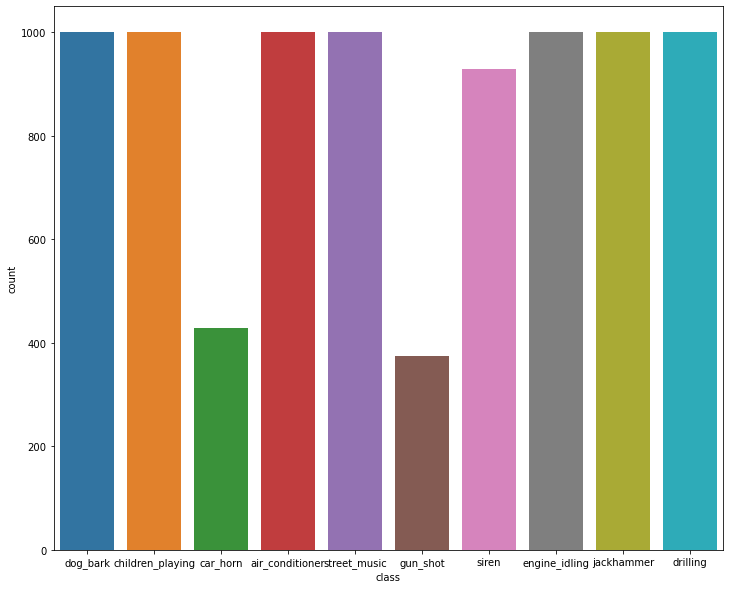

In [5]:
plt.figure(figsize=(12,10))
sns.countplot(metadata['class'])
plt.savefig('class.png')

Here we can see the Class labels are unbalanced. Although 7 out of the 10 classes all have exactly 1000 samples, and siren is not far off with 929, the remaining two (car_horn, gun_shot) have significantly less samples at 43% and 37% respectively.

This problem is solved by making the following decision about train set and test set based on the fact that the audio files of different classes are equally distributed among the folds.

In [6]:
#Librosa’s load function will convert the sampling rate to 22050 Hz automatically. 
fn = 'C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold5/100852-0-0-0.wav'
scipy_sample_rate, scipy_audio = wav.read(fn)
librosa_audio, librosa_sample_rate = librosa.load(fn)

print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 44100
Librosa sample rate: 22050


In [7]:
#It will also normalize the bit depth between -1 and 1.

print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -23628 to 27507
Librosa audio file min~max range: -0.50 to -0.50


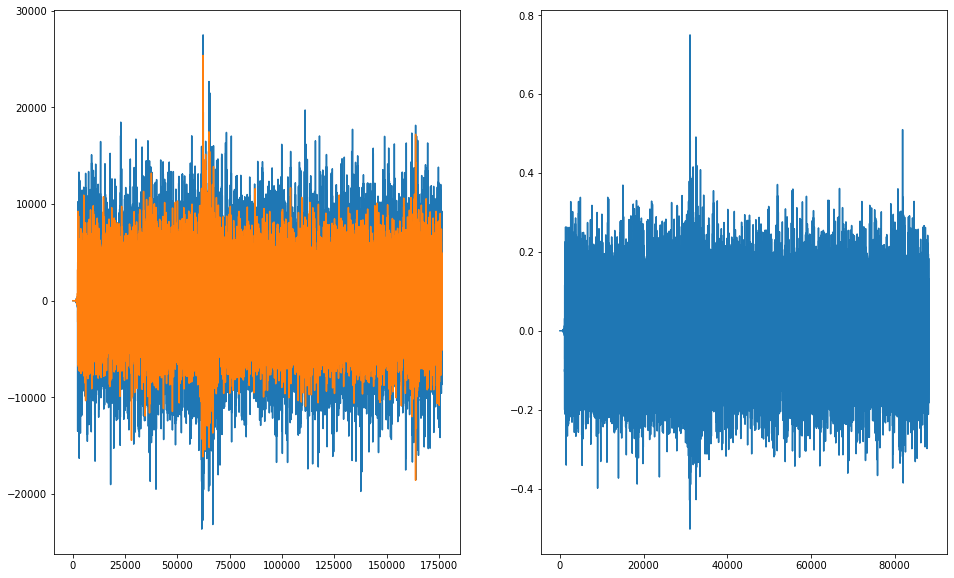

In [8]:
#Librosa also converts the audio signal to mono from stereo. 
#Original Audio: two audio sources
#Librosa Audio: one audio sources

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(scipy_audio)
plt.subplot(1, 2, 2)
plt.plot(librosa_audio)
plt.savefig('audio.png')

### Data splitting

In [9]:
appended = []
for i in range(1,11):
    appended.append(metadata[metadata.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,jackhammer,children_playing,street_music,drilling,dog_bark,air_conditioner,engine_idling,siren,car_horn,gun_shot
0,fold1,120,100,100,100,100,100,96,86,36,35
1,fold2,120,100,100,100,100,100,100,91,42,35
2,fold3,120,100,100,100,100,100,107,119,43,36
3,fold4,120,100,100,100,100,100,107,166,59,38
4,fold5,120,100,100,100,100,100,107,71,98,40
5,fold6,68,100,100,100,100,100,107,74,28,46
6,fold7,76,100,100,100,100,100,106,77,28,51
7,fold8,78,100,100,100,100,100,88,80,30,30
8,fold9,82,100,100,100,100,100,89,82,32,31
9,fold10,96,100,100,100,100,100,93,83,33,32


In [4]:
train_fold = [1, 2, 3, 4, 6]
test_fold = [5, 7, 8, 9, 10]

In [5]:
# Data Splitting
train_data = metadata.loc[metadata['fold'].isin(train_fold)]
test_data = metadata.loc[metadata['fold'].isin(test_fold)]

### Visual representation of dataset

In [12]:
# Class: Dog 
y_dog,sr_dog=librosa.load("C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold5/100032-3-0-0.wav")
mfccs_dog = librosa.feature.mfcc(y_dog,sr_dog, n_mfcc=25)
melspectrogram_dog=librosa.feature.melspectrogram(y=y_dog, sr=sr_dog, n_mels=40,fmax=8000)
chroma_stft_dog=librosa.feature.chroma_stft(y=y_dog, sr=sr_dog,n_chroma=20)
chroma_cqt_dog=librosa.feature.chroma_cqt(y=y_dog, sr=sr_dog,n_chroma=36)
chroma_cens_dog =librosa.feature.chroma_cens(y=y_dog, sr=sr_dog,n_chroma=36)

# Class: Air Conditioner
y_air,sr_air  = librosa.load('C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold5/100852-0-0-0.wav')
air_mfcc = librosa.feature.mfcc(y_air,sr_air, n_mfcc=25)
melspectrogram_air =librosa.feature.melspectrogram(y=y_air, sr=sr_air, n_mels=40,fmax=8000)
chroma_stft_air=librosa.feature.chroma_stft(y=y_air, sr=sr_air,n_chroma=20)
chroma_cqt_air=librosa.feature.chroma_cqt(y=y_air, sr=sr_air,n_chroma=36)
chroma_cens_air =librosa.feature.chroma_cens(y=y_air, sr=sr_air,n_chroma=36)

# Class: Car horn 
y_car,sr_car = librosa.load('C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold10/100648-1-0-0.wav')
mfccs_car = librosa.feature.mfcc(y_car,sr_car, n_mfcc=25)
melspectrogram_car =librosa.feature.melspectrogram(y=y_car, sr=sr_car, n_mels=40,fmax=8000)
chroma_stft_car = librosa.feature.chroma_stft(y=y_car, sr=sr_car,n_chroma=20)
chroma_cqt_car =librosa.feature.chroma_cqt(y=y_car, sr=sr_car,n_chroma=36)
chroma_cens_car =librosa.feature.chroma_cens(y=y_car, sr=sr_car, n_chroma=36)

# Class: Children playing 
y_children,sr_children =librosa.load('C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold5/100263-2-0-117.wav')
mfccs_children = librosa.feature.mfcc(y_children,sr_children, n_mfcc=25)
melspectrogram_children =librosa.feature.melspectrogram(y=y_children, sr=sr_children, n_mels=40,fmax=8000)
chroma_stft_children=librosa.feature.chroma_stft(y=y_children, sr=sr_children,n_chroma=20)
chroma_cqt_children=librosa.feature.chroma_cqt(y=y_children, sr=sr_children,n_chroma=36)
chroma_cens_children =librosa.feature.chroma_cens(y=y_children, sr=sr_children,n_chroma=36)

# Class: Drilling
y_drilling,sr_drilling = librosa.load('C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold3/103199-4-0-0.wav')
mfccs_drilling = librosa.feature.mfcc(y_drilling,sr_drilling, n_mfcc=25)
melspectrogram_drilling =librosa.feature.melspectrogram(y=y_drilling, sr=sr_drilling, n_mels=40,fmax=8000)
chroma_stft_drilling=librosa.feature.chroma_stft(y=y_drilling, sr=sr_drilling,n_chroma=20)
chroma_cqt_drilling=librosa.feature.chroma_cqt(y=y_drilling, sr=sr_drilling,n_chroma=36)
chroma_cens_drilling =librosa.feature.chroma_cens(y=y_drilling, sr=sr_drilling,n_chroma=36)

# Class: Engine Idling 
y_engine,sr_engine = librosa.load('C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold10/102857-5-0-0.wav')
mfccs_engine = librosa.feature.mfcc(y_engine,sr_engine, n_mfcc=25)
melspectrogram_engine=librosa.feature.melspectrogram(y=y_engine, sr=sr_engine, n_mels=40,fmax=8000)
chroma_stft_engine=librosa.feature.chroma_stft(y=y_engine, sr=sr_engine,n_chroma=20)
chroma_cqt_engine=librosa.feature.chroma_cqt(y=y_engine, sr=sr_engine,n_chroma=36)
chroma_cens_engine =librosa.feature.chroma_cens(y=y_engine, sr=sr_engine,n_chroma=36)

# Class: Gunshot
y_gunshot,sr_gunshot = librosa.load('C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold1/102305-6-0-0.wav')
melspectrogram_gunshot =librosa.feature.melspectrogram(y=y_gunshot, sr=sr_gunshot, n_mels=40,fmax=8000)
mfccs_gunshot = librosa.feature.mfcc(y_gunshot,sr_gunshot, n_mfcc=25)
chroma_stft_gunshot=librosa.feature.chroma_stft(y=y_gunshot, sr=sr_gunshot,n_chroma=20)
chroma_cqt_gunshot=librosa.feature.chroma_cqt(y=y_gunshot, sr=sr_gunshot,n_chroma=36)
chroma_cens_gunshot =librosa.feature.chroma_cens(y=y_gunshot, sr=sr_gunshot,n_chroma=36)

# Class: Jackhammer
y_jackhammer,sr_jackhammer = librosa.load('C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold1/103074-7-0-0.wav')
mfccs_jackhammer = librosa.feature.mfcc(y_jackhammer,sr_jackhammer, n_mfcc=25)
melspectrogram_jackhammer =librosa.feature.melspectrogram(y=y_jackhammer, sr=sr_jackhammer, n_mels=40,fmax=8000)
chroma_stft_jackhammer=librosa.feature.chroma_stft(y=y_jackhammer, sr=sr_jackhammer,n_chroma=20)
chroma_cqt_jackhammer=librosa.feature.chroma_cqt(y=y_jackhammer, sr=sr_jackhammer,n_chroma=36)
chroma_cens_jackhammer =librosa.feature.chroma_cens(y=y_jackhammer, sr=sr_jackhammer,n_chroma=36)

# Class: Siren
y_siren,sr_siren = librosa.load('C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold7/102853-8-0-0.wav')
mfccs_siren = librosa.feature.mfcc(y_siren,sr_siren, n_mfcc=25)
melspectrogram_siren=librosa.feature.melspectrogram(y=y_siren, sr=sr_siren, n_mels=40,fmax=8000)
chroma_stft_siren=librosa.feature.chroma_stft(y=y_siren, sr=sr_siren,n_chroma=20)
chroma_cqt_siren=librosa.feature.chroma_cqt(y=y_siren, sr=sr_siren,n_chroma=36)
chroma_cens_siren =librosa.feature.chroma_cens(y=y_siren, sr=sr_siren,n_chroma=36)

# Class: Street music
y_street,sr_street = librosa.load('C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold7/101848-9-0-0.wav')
mfccs_street = librosa.feature.mfcc(y_street,sr_street, n_mfcc=25)
melspectrogram_street = librosa.feature.melspectrogram(y=y_street, sr=sr_street, n_mels=40,fmax=8000)
chroma_stft_street = librosa.feature.chroma_stft(y=y_street, sr=sr_street,n_chroma=20)
chroma_cqt_street = librosa.feature.chroma_cqt(y=y_street, sr=sr_street,n_chroma=36)
chroma_cens_street = librosa.feature.chroma_cens(y=y_street, sr=sr_street,n_chroma=36)

C:\Users\USER\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=876
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=438
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=219
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=110
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=894
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=447
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\librosa\core\spe

### Waveplot

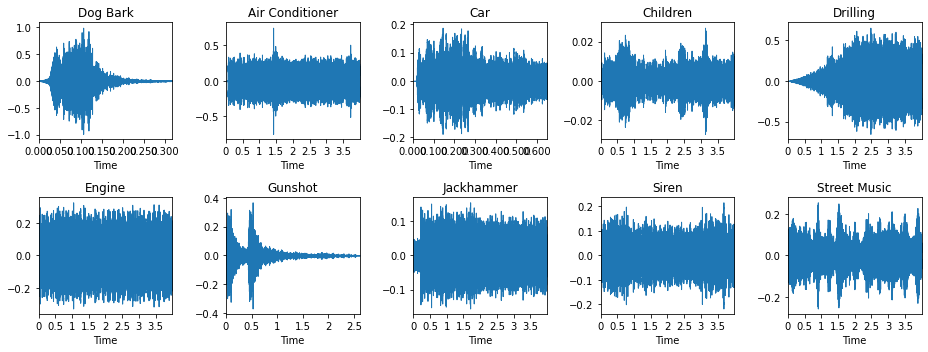

In [13]:
plt.figure(figsize=(13,5))

plt.subplot(2, 5, 1)
plt.title('Dog Bark')
dog = librosa.display.waveplot(y_dog,sr_dog)
#ipd.Audio(filename_dog)


plt.subplot(2, 5, 2) 
plt.title('Air Conditioner')
air = librosa.display.waveplot(y_air,sr_air)
#ipd.Audio(filename_dog)

plt.subplot(2, 5, 3)
plt.title('Car')
car = librosa.display.waveplot(y_car,sr_car)
#ipd.Audio(filename_car)

plt.subplot(2, 5, 4)
plt.title('Children')
car = librosa.display.waveplot(y_children,sr_children)
#ipd.Audio(filename_car)

plt.subplot(2, 5, 5)
plt.title('Drilling')
car = librosa.display.waveplot(y_drilling,sr_drilling)
#ipd.Audio(filename_car)

plt.subplot(2, 5, 6)
plt.title('Engine')
car = librosa.display.waveplot(y_engine,sr_engine)
#ipd.Audio(filename_car)

plt.subplot(2, 5, 7)
plt.title('Gunshot')
car = librosa.display.waveplot(y_gunshot,sr_gunshot)
#ipd.Audio(filename_car)

plt.subplot(2, 5, 8)
plt.title('Jackhammer')
car = librosa.display.waveplot(y_jackhammer,sr_jackhammer)
#ipd.Audio(filename_car)

plt.subplot(2, 5, 9)
plt.title('Siren')
car = librosa.display.waveplot(y_siren,sr_siren)
#ipd.Audio(filename_car)

plt.subplot(2, 5, 10)
plt.title('Street Music')
car = librosa.display.waveplot(y_street,sr_street)
#ipd.Audio(filename_car)

plt.tight_layout()
plt.savefig('waveplot.png')

### MFCC 

 Mel-Frequency Cepstral Coefficients (MFCC): summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification. It is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. Mel-frequency cepstral coefficients are coefficients that collectively make up an MFC

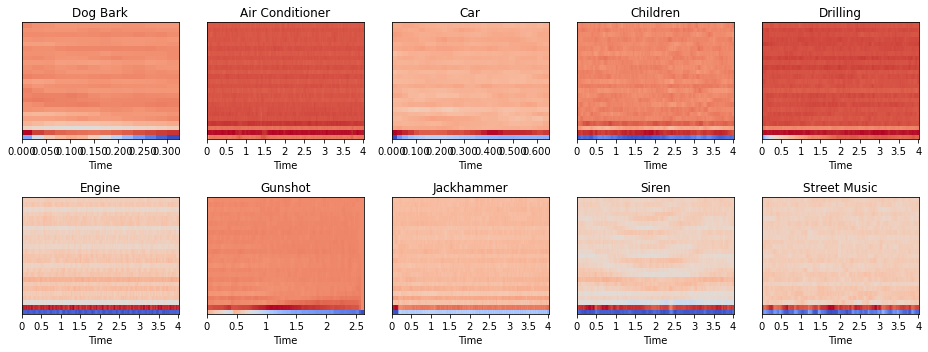

In [14]:
plt.figure(figsize=(13,5))

plt.subplot(2, 5, 1)
plt.title('Dog Bark')
mfccs_dog = librosa.display.specshow(mfccs_dog, x_axis='time')

plt.subplot(2, 5, 2) 
plt.title('Air Conditioner')
mfccs_air = librosa.display.specshow(air_mfcc, x_axis='time')

plt.subplot(2, 5, 3)
plt.title('Car')
mfccs_car = librosa.display.specshow(mfccs_car, x_axis='time')

plt.subplot(2, 5, 4)
plt.title('Children')
mfccs_children = librosa.display.specshow(mfccs_children, x_axis='time')

plt.subplot(2, 5, 5)
plt.title('Drilling')
mfccs_drilling = librosa.display.specshow(mfccs_drilling, x_axis='time')

plt.subplot(2, 5, 6)
plt.title('Engine')
mfccs_engine = librosa.display.specshow(mfccs_engine, x_axis='time')

plt.subplot(2, 5, 7)
plt.title('Gunshot')
mfccs_gunshot = librosa.display.specshow(mfccs_gunshot, x_axis='time')

plt.subplot(2, 5, 8)
plt.title('Jackhammer')
mfccs_jackhammer = librosa.display.specshow(mfccs_jackhammer, x_axis='time')

plt.subplot(2, 5, 9)
plt.title('Siren')
mfccs_siren = librosa.display.specshow(mfccs_siren, x_axis='time')

plt.subplot(2, 5, 10)
plt.title('Street Music')
mfccs_street = librosa.display.specshow(mfccs_street, x_axis='time')

plt.tight_layout()
plt.savefig('mfcc.png')

### MeL Scale spectrogram

The Mel Scale, mathematically speaking, is the result of some non-linear transformation of the frequency scale. This Mel Scale is constructed such that sounds of equal distance from each other on the Mel Scale, also “sound” to humans as they are equal in distance from one another.
In contrast to Hz scale, where the difference between 500 and 1000 Hz is obvious, whereas the difference between 7500 and 8000 Hz is barely noticeable.

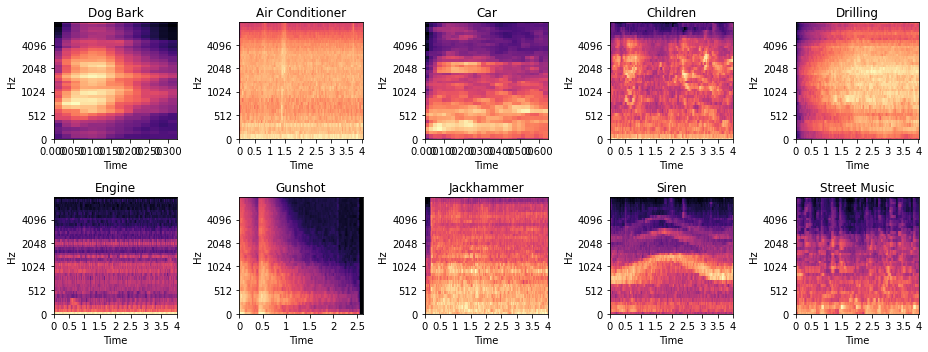

In [15]:
#Melspectrogram 
plt.figure(figsize=(13,5))

plt.subplot(2, 5, 1)
plt.title('Dog Bark')
dog_mel = librosa.display.specshow(librosa.power_to_db(melspectrogram_dog,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')

plt.subplot(2, 5, 2) 
plt.title('Air Conditioner')
air_mel = librosa.display.specshow(librosa.power_to_db(melspectrogram_air,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')

plt.subplot(2, 5, 3)
plt.title('Car')
car_mel = librosa.display.specshow(librosa.power_to_db(melspectrogram_car,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')

plt.subplot(2, 5, 4)
plt.title('Children')
children_mel = librosa.display.specshow(librosa.power_to_db(melspectrogram_children,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')

plt.subplot(2, 5, 5)
plt.title('Drilling')
drilling_mel = librosa.display.specshow(librosa.power_to_db(melspectrogram_drilling,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')

plt.subplot(2, 5, 6)
plt.title('Engine')
engine_mel = librosa.display.specshow(librosa.power_to_db(melspectrogram_engine,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')

plt.subplot(2, 5, 7)
plt.title('Gunshot')
gunshot_mel = librosa.display.specshow(librosa.power_to_db(melspectrogram_gunshot,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')

plt.subplot(2, 5, 8)
plt.title('Jackhammer')
jackhammer_mel = librosa.display.specshow(librosa.power_to_db(melspectrogram_jackhammer,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')

plt.subplot(2, 5, 9)
plt.title('Siren')
siren_mel = librosa.display.specshow(librosa.power_to_db(melspectrogram_siren,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')

plt.subplot(2, 5, 10)
plt.title('Street Music')
street_mel = librosa.display.specshow(librosa.power_to_db(melspectrogram_street,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')

plt.tight_layout()
plt.savefig('mel.png')

### Chromagram STFT

Chromagram short-time Fourier transform (STFT): convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image, useful to convert the audio into the time-frequency domain.

A Fourier transform (`tf.signal.sfft`) converts a signal to its component frequencies, but loses all time information. The STFT splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase.

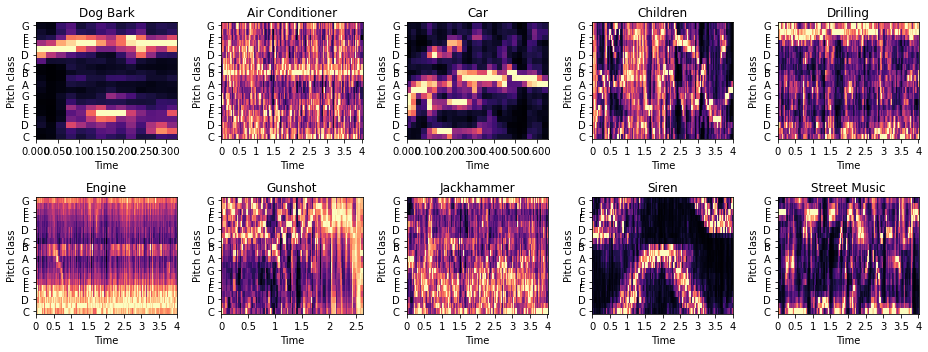

In [16]:
#Chromagram
plt.figure(figsize=(13,5))

plt.subplot(2, 5, 1)
plt.title('Dog Bark')
dog_chroma = librosa.display.specshow(chroma_stft_dog, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 2) 
plt.title('Air Conditioner')
air_chroma = librosa.display.specshow(chroma_stft_air, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 3)
plt.title('Car')
car_chroma = librosa.display.specshow(chroma_stft_car, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 4)
plt.title('Children')
children_chroma = librosa.display.specshow(chroma_stft_children, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 5)
plt.title('Drilling')
drilling_chroma = librosa.display.specshow(chroma_stft_drilling, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 6)
plt.title('Engine')
engine_chroma = librosa.display.specshow(chroma_stft_engine, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 7)
plt.title('Gunshot')
gunshot_chroma = librosa.display.specshow(chroma_stft_gunshot, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 8)
plt.title('Jackhammer')
jackhammer_chroma = librosa.display.specshow(chroma_stft_jackhammer, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 9)
plt.title('Siren')
siren_chroma = librosa.display.specshow(chroma_stft_siren, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 10)
plt.title('Street Music')
street_chroma = librosa.display.specshow(chroma_stft_street, y_axis='chroma', x_axis='time')

plt.tight_layout()
plt.savefig('stft.png')

### Chromagram cqt

Chroma Constant-Q Transform (Cqt): unlike the Fourier transform, but similar to the mel scale, uses a logarithmically spaced frequency axis

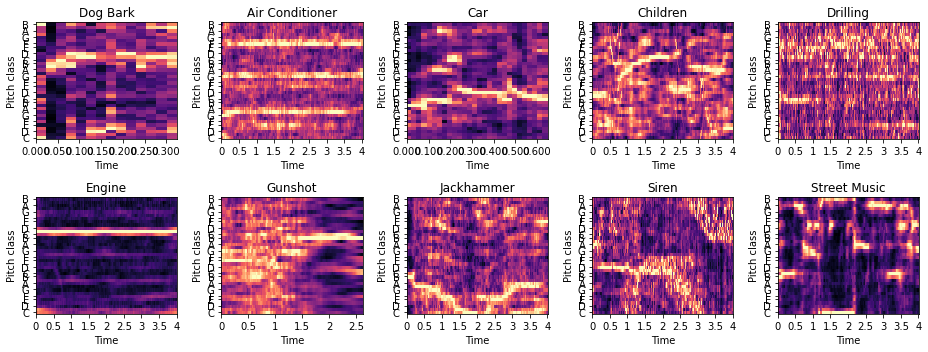

In [17]:
#Chroma cqt 
plt.figure(figsize=(13,5))

plt.subplot(2, 5, 1)
plt.title('Dog Bark')
dog_cqt = librosa.display.specshow(chroma_cqt_dog, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 2) 
plt.title('Air Conditioner')
air_cqt = librosa.display.specshow(chroma_cqt_air, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 3)
plt.title('Car')
car_cqt = librosa.display.specshow(chroma_cqt_car, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 4)
plt.title('Children')
children_cqt = librosa.display.specshow(chroma_cqt_children, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 5)
plt.title('Drilling')
drilling_cqt = librosa.display.specshow(chroma_cqt_drilling, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 6)
plt.title('Engine')
engine_cqt = librosa.display.specshow(chroma_cqt_engine, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 7)
plt.title('Gunshot')
gunshot_cqt = librosa.display.specshow(chroma_cqt_gunshot, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 8)
plt.title('Jackhammer')
jackhammer_cqt = librosa.display.specshow(chroma_cqt_jackhammer, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 9)
plt.title('Siren')
siren_cqt = librosa.display.specshow(chroma_cqt_siren, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 10)
plt.title('Street Music')
street_cqt = librosa.display.specshow(chroma_cqt_street, y_axis='chroma', x_axis='time')

plt.tight_layout()
plt.savefig('cqt.png')

### Chromagram cens

Chroma energy normalized statistics (CENS): the main idea of CENS features is that taking statistics over large windows smooths local deviations in tempo, articulation, and musical ornaments such as trills and arpeggiated chords. CENS are best used for tasks such as audio matching and similarity

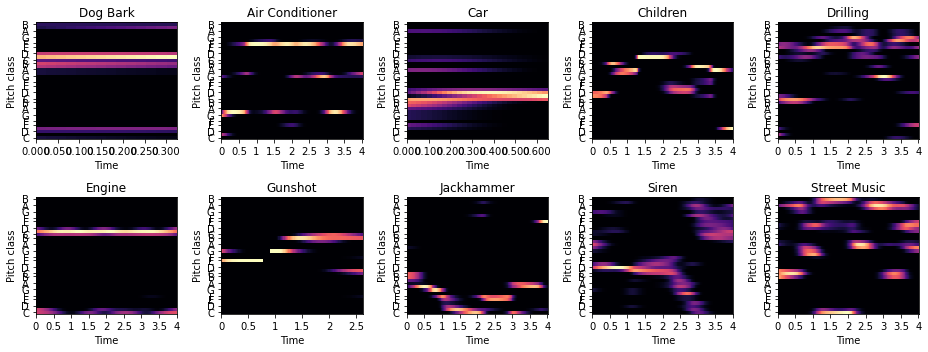

In [18]:
#Chroma cens
plt.figure(figsize=(13,5))

plt.subplot(2, 5, 1)
plt.title('Dog Bark')
dog_cens = librosa.display.specshow(chroma_cens_dog, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 2) 
plt.title('Air Conditioner')
air_cens = librosa.display.specshow(chroma_cens_air, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 3)
plt.title('Car')
car_cens = librosa.display.specshow(chroma_cens_car, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 4)
plt.title('Children')
children_cens = librosa.display.specshow(chroma_cens_children, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 5)
plt.title('Drilling')
drilling_cens = librosa.display.specshow(chroma_cens_drilling, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 6)
plt.title('Engine')
engine_cens = librosa.display.specshow(chroma_cens_engine, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 7)
plt.title('Gunshot')
gunshot_cens = librosa.display.specshow(chroma_cens_gunshot, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 8)
plt.title('Jackhammer')
jackhammer_cens = librosa.display.specshow(chroma_cens_jackhammer, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 9)
plt.title('Siren')
siren_cens = librosa.display.specshow(chroma_cens_siren, y_axis='chroma', x_axis='time')

plt.subplot(2, 5, 10)
plt.title('Street Music')
street_cens = librosa.display.specshow(chroma_cens_street, y_axis='chroma', x_axis='time')

plt.tight_layout()
plt.savefig('cens.png')

# Mel-Frequency Cepstral Coefficients vs Chroma Sftf

### Feature Extraction 

In [ ]:
# Extracting MFCC's and Chroma stft for every audio file
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name) 
    #mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate,n_mfcc=25) #25 coefficients
    mfccs_features = librosa.feature.chroma_stft(y=audio, sr=sample_rate) #12 chroma 
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0) #temporal averaging
    
    return mfccs_scaled_features

In [ ]:
audio_dataset_path = 'C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio'

In [ ]:
# Features extraction from all audio files
extracted_features_stft=[]
for index_num,row in tqdm(train_data.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    fold=row["fold"]
    data=features_extractor(file_name)
    extracted_features_stft.append([data,final_class_labels]) 

In [ ]:
with open('extracted_features.pkl', 'wb') as b:
    pickle.dump(extracted_features,b)

In [ ]:
with open('extracted_features_stft.pkl', 'wb') as b:
    pickle.dump(extracted_features_stft,b)

In [ ]:
# Converting extracted_features to Pandas dataframe
mfcc_features_df=pd.DataFrame(extracted_features,columns=['features_mfcc','class']) 
mfcc_features_df.head()

In [ ]:
mfcc_features_df.to_pickle("mfcc_features_df.pkl") 

In [ ]:
# Converting extracted_features to Pandas dataframe
stft_features_df=pd.DataFrame(extracted_features_stft,columns=['features_stft','class'])
stft_features_df.head()

In [ ]:
stft_features_df.to_pickle("stft_features_df.pkl") 

In [ ]:
# Features extraction from all audio files (MFCC & STFT)
extracted_features_test_stft=[]
for index_num,row in tqdm(test_data.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    fold=row["fold"]
    data=features_extractor(file_name)
    extracted_features_test_stft.append([data,final_class_labels])

In [ ]:
with open('extracted_features_test.pkl', 'wb') as b:
    pickle.dump(extracted_features_test,b)

In [ ]:
with open('extracted_features_test_stft.pkl', 'wb') as b:
    pickle.dump(extracted_features_test_stft,b)

In [ ]:
# Converting extracted_features to Pandas dataframe
mfcctest_features_df=pd.DataFrame(extracted_features_test,columns=['features_mfcc','class'])
mfcctest_features_df.head()

In [ ]:
# Converting extracted_features to Pandas dataframe
stfttest_features_df=pd.DataFrame(extracted_features_test_stft,columns=['features_stft','class'])
stfttest_features_df.head()

In [ ]:
mfcctest_features_df.to_pickle("mfcctest_features_df.pkl") 

In [ ]:
stfttest_features_df.to_pickle("stfttest_features_df.pkl") 

In [19]:
#Read pkl file opinion_data
mfcc_features_df = pd.read_pickle("mfcc_features_df.pkl")

In [20]:
#Read pkl file opinion_data
mfcctest_features_df = pd.read_pickle("mfcctest_features_df.pkl")

In [48]:
#Read pkl file opinion_data
stft_features_df = pd.read_pickle("stft_features_df.pkl")

In [49]:
#Read pkl file opinion_data
stfttest_features_df = pd.read_pickle("stfttest_features_df.pkl")

In [ ]:
mfcc_features_df.iloc[0]['features_mfcc']

In [ ]:
mfcctest_features_df.iloc[0]['features_mfcc']

In [ ]:
stft_features_df.iloc[0]['features_stft']

In [ ]:
stfttest_features_df.iloc[0]['features_stft']

### Data encoding

In [21]:
X_train=np.array(mfcc_features_df['features_mfcc'].tolist())
y_train=np.array(mfcc_features_df['class'].tolist())
X_test=np.array(mfcctest_features_df['features_mfcc'].tolist())
y_test=np.array(mfcctest_features_df['class'].tolist())

In [50]:
X_train=np.array(stft_features_df['features_stft'].tolist())
y_train=np.array(stft_features_df['class'].tolist())
X_test=np.array(stfttest_features_df['features_stft'].tolist())
y_test=np.array(stfttest_features_df['class'].tolist())

In [51]:
# Label Encoding
labelencoder=LabelEncoder()
y_train=to_categorical(labelencoder.fit_transform(y_train))
y_test=to_categorical(labelencoder.fit_transform(y_test))

In [52]:
y_train.shape

(4499, 10)

In [53]:
#Number of classes
num_labels=y_train.shape[1]
print(num_labels)

10


## Multilayer Perceptron Model - MFCC

### Parameter tuning

##### Step 1  - Choosing the `number of neurons` and of `hidden layers`

In [25]:
def create_model(n_hidden=1, n_neurons=10): 
    model = Sequential()
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, input_shape=[25,], activation="relu"))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [26]:
keras_clas = tf.keras.wrappers.scikit_learn.KerasClassifier(create_model)

In [27]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define the random search parameters
param_distribs = dict(
            n_hidden = [1,2,3,4,5],
            n_neurons=[10,20,30,40,50,60,70,80,90,100])

In [28]:
rnd_search_cv = RandomizedSearchCV(keras_clas, param_distribs, cv=3, verbose=1)
rnd_search_cv.fit(X_train, y_train,validation_data=(X_test,y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
141/141 [==============================] - 2s 6ms/step - loss: 3.1010 - accuracy: 0.2661 - val_loss: 1.9555 - val_accuracy: 0.3702


RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001540A629610>,
                   param_distributions={'n_hidden': [1, 2, 3, 4, 5],
                                        'n_neurons': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100]},
                   verbose=1)

In [29]:
# summarize results
print("Best: %f using %s" % (rnd_search_cv.best_score_, rnd_search_cv.best_params_))

Best: 0.290063 using {'n_neurons': 70, 'n_hidden': 4}


##### Step 2 - `Number of epochs` and `batch_size`

We will start with 
- `epochs` which is the number of times the model will cycle through the data. 
- `batch_size`, as having a large batch size can reduce the generalisation ability of the model
- `verbose` argument can be set to 1 to discover the training epoch on which training was stopped, set to 0 otherwise
. 


In [30]:
# Use scikit-learn to grid search the batch size and epochs
def create_model():
    model = Sequential()
    model.add(Dense(70, input_shape=[25,], activation='relu'))
    model.add(Dense(70, input_shape=[25,], activation='relu'))
    model.add(Dense(70, input_shape=[25,], activation='relu'))
    model.add(Dense(70, input_shape=[25,], activation='relu'))
    model.add(Dense(num_labels, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [31]:
# create model
model =tf.keras.wrappers.scikit_learn.KerasClassifier(create_model)

In [32]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define the random search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10,20,30,40,50,60,70,80,90,100]
param_distribs = dict(batch_size=batch_size, epochs=epochs)

In [33]:
rnd_search_cv_bs = RandomizedSearchCV(model, param_distribs, cv=3, verbose=1)
rnd_search_cv_bs.fit(X_train, y_train,validation_data=(X_test,y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/20
50/50 [==============================] - 1s 14ms/step - loss: 6.6767 - accuracy: 0.1922 - val_loss: 2.3805 - val_accuracy: 0.2799
Epoch 2/20
50/50 [==============================] - 0s 7ms/step - loss: 1.5448 - accuracy: 0.5050 - val_loss: 2.1436 - val_accuracy: 0.3541
Epoch 3/20
50/50 [==============================] - 0s 7ms/step - loss: 1.1905 - accuracy: 0.5970 - val_loss: 2.1462 - val_accuracy: 0.3485
Epoch 4/20
50/50 [==============================] - 0s 7ms/step - loss: 1.0159 - accuracy: 0.6568 - val_loss: 2.1864 - val_accuracy: 0.3841
Epoch 5/20
50/50 [==============================] - 0s 7ms/step - loss: 0.9395 - accuracy: 0.7072 - val_loss: 2.0694 - val_accuracy: 0.3903
Epoch 6/20
50/50 [==============================] - 0s 7ms/step - loss: 0.8409 - accuracy: 0.7163 - val_loss: 2.2060 - val_accuracy: 0.3912
Epoch 7/20
50/50 [==============================] - 0s 7ms/step - loss: 0.7654 - accuracy: 0.7591 

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001541292C730>,
                   param_distributions={'batch_size': [10, 20, 40, 60, 80, 100],
                                        'epochs': [10, 20, 30, 40, 50, 60, 70,
                                                   80, 90, 100]},
                   verbose=1)

In [34]:
# summarize results
print("Best: %f using %s" % (rnd_search_cv_bs.best_score_,rnd_search_cv_bs.best_params_))

Best: 0.341183 using {'epochs': 50, 'batch_size': 80}


##### Step 3 - `Dropout`

In [40]:
from keras.constraints import maxnorm
# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.1):
    model = Sequential()
    model.add(Dense(70, input_shape=[25,], activation='relu'))
    model.add(Dense(70, input_shape=[25,], activation='relu'))
    model.add(Dense(70, input_shape=[25,], activation='relu'))
    model.add(Dense(70, input_shape=[25,], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [41]:
# create model
model = tf.keras.wrappers.scikit_learn.KerasClassifier(create_model)

In [42]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define the random search parameters
dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
param_distribs = dict(dropout_rate=dropout_rate)

In [43]:
rnd_search_cv_d = RandomizedSearchCV(model, param_distribs, cv=3, verbose=1)
rnd_search_cv_d = rnd_search_cv_d.fit(X_train, y_train,validation_data=(X_test,y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 5 candidates, totalling 15 fits
141/141 [==============================] - 5s 16ms/step - loss: 5.8262 - accuracy: 0.2249 - val_loss: 1.9976 - val_accuracy: 0.3444


In [44]:
# summarize results
print("Best: %f using %s" % (rnd_search_cv_d.best_score_, rnd_search_cv_d.best_params_))

Best: 0.262730 using {'dropout_rate': 0.2}


##### Step 4 - `Callbacks`

A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the `.fit()` method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.

- `keras.callbacks.History()` this is automatically included in `.fit()`.
- `keras.callbacks.ModelCheckpoint` which saves the model with its weights at a certain point in the training. This can prove useful if your model is running for a long time and a system failure happens. 
- `keras.callbacks.EarlyStopping` stops the training when a monitored quantity has stopped improving.
- `keras.callbacks.LearningRateScheduler` will change the learning rate during training.

### Model creation

In [45]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [46]:
model=Sequential()

###first layer
model.add(Dense(70,input_shape=(25,)))
model.add(Activation('relu')) 
model.add(Dropout(0.2))

###second layer
model.add(Dense(70,input_shape=(25,)))
model.add(Activation('relu')) 
model.add(Dropout(0.2))

###third layer
model.add(Dense(70,input_shape=(25,)))
model.add(Activation('relu')) 
model.add(Dropout(0.2))

###fourth layer
model.add(Dense(70,input_shape=(25,)))
model.add(Activation('relu')) 
model.add(Dropout(0.2))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax')) 

### Compiling the model 

For compiling our model, we will use the following three parameters:

- Loss function - `categorical_crossentropy` most common choice for classification:a lower score indicates that the model is performing better.

- Metrics - the `accuracy` metric which will allow us to view the accuracy score on the validation data when we train the model.

- Optimizer - `adam` which is a generally good optimizer for many use cases.

In [47]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_437 (Dense)            (None, 70)                1820      
_________________________________________________________________
activation (Activation)      (None, 70)                0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_438 (Dense)            (None, 70)                4970      
_________________________________________________________________
activation_1 (Activation)    (None, 70)                0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_439 (Dense)            (None, 70)              

### Training the model 

Here we will train the model.

In [48]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

num_epochs = 50 
num_batch_size = 80

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
                    validation_data=(X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]) 

Epoch 1/50
57/57 [==============================] - 4s 31ms/step - loss: 11.8949 - accuracy: 0.1090 - val_loss: 2.2647 - val_accuracy: 0.1713
Epoch 2/50
57/57 [==============================] - 1s 17ms/step - loss: 3.0083 - accuracy: 0.1441 - val_loss: 2.1825 - val_accuracy: 0.1793
Epoch 3/50
57/57 [==============================] - 1s 16ms/step - loss: 2.4155 - accuracy: 0.1898 - val_loss: 2.1582 - val_accuracy: 0.1748
Epoch 4/50
57/57 [==============================] - 1s 16ms/step - loss: 2.2790 - accuracy: 0.1884 - val_loss: 2.1293 - val_accuracy: 0.2086
Epoch 5/50
57/57 [==============================] - 1s 17ms/step - loss: 2.2060 - accuracy: 0.2218 - val_loss: 2.1034 - val_accuracy: 0.2294
Epoch 6/50
57/57 [==============================] - 1s 18ms/step - loss: 2.1118 - accuracy: 0.2383 - val_loss: 2.0864 - val_accuracy: 0.2499
Epoch 7/50
57/57 [==============================] - 1s 17ms/step - loss: 2.0608 - accuracy: 0.2621 - val_loss: 2.0679 - val_accuracy: 0.2471
Epoch 8/50
5

In [49]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.6825961470603943
Testing Accuracy:  0.4637373089790344


In [50]:
predict_x=model.predict(X_test,verbose=0) 
classes_x=np.argmax(predict_x,axis=1)

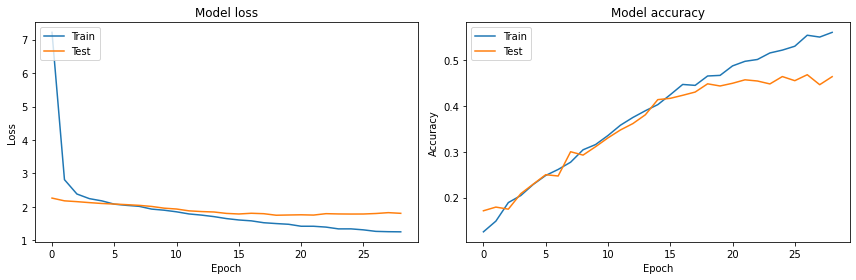

In [51]:
plt.figure(figsize=(12, 4))
metrics = history.history

plt.subplot(1, 2, 1)
plt.title('Model loss')
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left') 

plt.subplot(1, 2, 2)
plt.title('Model accuracy')
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
#plt.show()


### Confusion matrix

In [52]:
# Predict probabilities for test set
y_probs = model.predict(X_test)

In [53]:
# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test, axis=1)

In [54]:
# Add "pred" column
test_data['pred'] = yhat_probs

<ipython-input-54-c3152a5c3e3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred'] = yhat_probs


In [55]:
np.set_printoptions(precision=2)

In [56]:
# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)
print(cm)

[[131   5  44  29  15  68  17  65  10 116]
 [  8  97  21   2  11  16   1  15   1  49]
 [ 25   8 313  40  19  33   0   9  11  42]
 [ 24   3  60 314  15  23   3   2  22  34]
 [  9   3  54  30 181  39   1  98  19  66]
 [107   0  64  24   6 251   1   4  16  10]
 [  4   0  29  89   6   1  42   2   4   7]
 [ 20   0  12   1 166  25   0 207   0  21]
 [ 44   1  30  44   4  22   0   3 239   6]
 [ 47   8  98  26  27  27   4  53  22 188]]


In [57]:
# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.31      0.26      0.29       500
        Car Horn       0.78      0.44      0.56       221
Children Playing       0.43      0.63      0.51       500
        Dog bark       0.52      0.63      0.57       500
        Drilling       0.40      0.36      0.38       500
   Engine Idling       0.50      0.52      0.51       483
        Gun Shot       0.61      0.23      0.33       184
      Jackhammer       0.45      0.46      0.45       452
           Siren       0.69      0.61      0.65       393
    Street Music       0.35      0.38      0.36       500

        accuracy                           0.46      4233
       macro avg       0.50      0.45      0.46      4233
    weighted avg       0.48      0.46      0.46      4233



In [58]:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
 
    plt.figure(figsize=(16, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  

Normalized confusion matrix


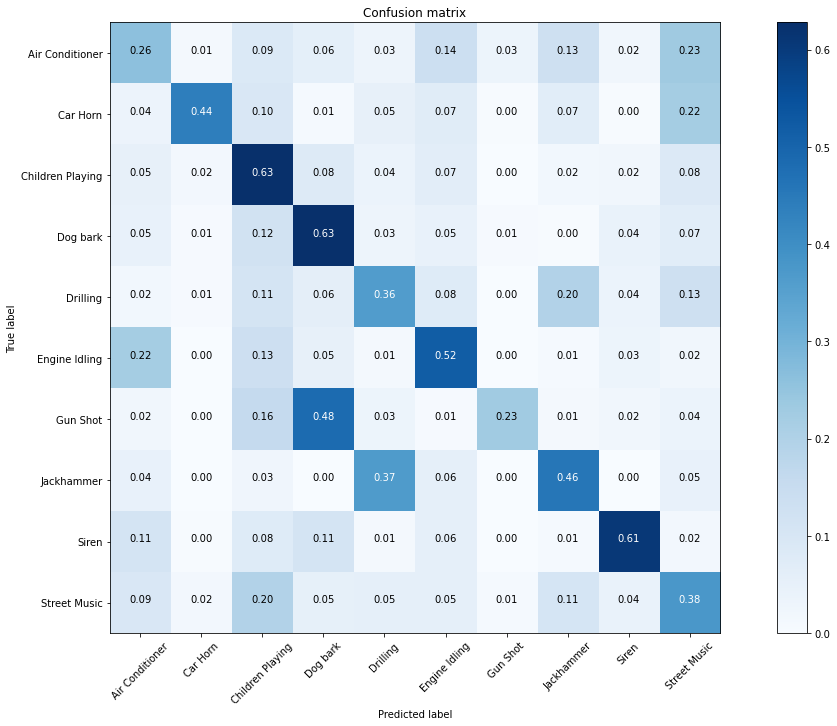

In [59]:
plot_confusion_matrix(cm,labels, normalize = True)

### Evaluate the model with CV

In [ ]:
# Extracting MFCC's and Chroma stft for every audio file
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate,n_mfcc=25) #25 coefficients
    #mfccs_features = librosa.feature.chroma_stft(y=audio, sr=sample_rate) #12 chroma #np.abs()
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0) #temporal averaging
    
    return mfccs_scaled_features

In [ ]:
audio_dataset_path = 'C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio'

In [ ]:
features = []

for index,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/'+str(row["slice_file_name"]))
    label_class = str(row["class"])
    data = features_extractor(file_name)
    features.append([data,label_class])

In [ ]:
with open('features.pkl', 'wb') as b:
    pickle.dump(features,b)

In [ ]:
features_df = pd.DataFrame(features,columns=['Features','Class'])
features_df.head()

In [ ]:
features_df.to_pickle("features_df.pkl") 

In [60]:
#Read pkl file opinion_data
features_df = pd.read_pickle("features_df.pkl")

In [61]:
X = np.array(features_df['Features'].tolist())
Y_labels = np.array(features_df['Class'].tolist())

In [62]:
labelencoder = LabelEncoder()
Y = to_categorical(labelencoder.fit_transform(Y_labels))

In [63]:
def model_mfcc():
    
    model_mfcc = models.Sequential()
    model_mfcc.add(Dense(70, input_shape=(25,)))
    model_mfcc.add(Activation('relu'))
    model_mfcc.add(Dropout(0.2))

    model_mfcc.add(Dense(70, input_shape=(25,)))
    model_mfcc.add(Activation('relu'))
    model_mfcc.add(Dropout(0.2))
    
    model_mfcc.add(Dense(70, input_shape=(25,)))
    model_mfcc.add(Activation('relu'))
    model_mfcc.add(Dropout(0.2))
    
    model_mfcc.add(Dense(70, input_shape=(25,)))
    model_mfcc.add(Activation('relu'))
    model_mfcc.add(Dropout(0.2))

    model_mfcc.add(Dense(num_labels))
    model_mfcc.add(Activation('softmax'))

    model_mfcc.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model_mfcc

In [64]:
estimator = KerasClassifier(build_fn=model_mfcc, epochs=50, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 79.90% (2.19%)


### Testing new audio files

Here we will test the model with an audio file.

In [65]:
filename='C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold8/103076-3-0-0.wav' #(dog)
audio, sample_rate = librosa.load(filename) 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=25)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
print(mfccs_scaled_features)

[-435.73   58.07   -3.23  -19.8   -20.76  -22.43  -19.74  -11.36   -9.98
    0.53    3.52    1.43    1.46    3.38    5.22    1.69   -3.61   -3.6
   -6.45   -8.58   -8.43   -4.63   -2.14    2.47    1.75]


In [66]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape) 

(1, 25)


In [67]:
predicted_label=model.predict(mfccs_scaled_features)
print(predicted_label)

[[9.77e-06 7.22e-04 3.87e-02 6.64e-01 2.84e-03 1.43e-04 2.69e-01 1.90e-07
  2.28e-02 1.35e-03]]


In [68]:
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
prediction_class

array(['dog_bark'], dtype='<U16')

In [69]:
ipd.Audio(filename) 

## Multilayer Perceptron Model - CHROMA STFT

### Parameter tuning

##### Step 1  - Choosing the `number of neurons` and of `hidden layers`

In [12]:
def create_model(n_hidden=1, n_neurons=30): 
    model = Sequential()
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, input_shape=[12,], activation="relu"))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [13]:
keras_clas = tf.keras.wrappers.scikit_learn.KerasClassifier(create_model)

In [14]:
# fix random seed for reproducibility
seed = 78
np.random.seed(seed)

# define the random search parameters
n_hidden = [0, 1, 2, 3, 4, 5]
n_neurons = [10,20,30,40,50,60,70,80,90,100]
             
param_distribs = dict(n_neurons=n_neurons, n_hidden=n_hidden)

In [15]:
rnd_search_cv = RandomizedSearchCV(keras_clas, param_distribs, cv=3, verbose=1)
rnd_search_cv.fit(X_train, y_train,validation_data=(X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
141/141 [==============================] - 5s 18ms/step - loss: 2.2532 - accuracy: 0.1280 - val_loss: 2.1304 - val_accuracy: 0.1691


RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000020B2B3353D0>,
                   param_distributions={'n_hidden': [0, 1, 2, 3, 4, 5],
                                        'n_neurons': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100]},
                   verbose=1)

In [16]:
# summarize results
print("Best: %f using %s" % (rnd_search_cv.best_score_, rnd_search_cv.best_params_))

Best: 0.108693 using {'n_neurons': 100, 'n_hidden': 3}


##### Step 2 - `Number of epochs` and `batch_size`

We will start with 
- `epochs` which is the number of times the model will cycle through the data. 
- `batch_size`, as having a large batch size can reduce the generalisation ability of the model
- `verbose` argument can be set to 1 to discover the training epoch on which training was stopped, set to 0 otherwise
. 


In [17]:
# Use scikit-learn to grid search the batch size and epochs
def create_model():
    model = Sequential()
    model.add(Dense(100, input_shape=[12,], activation='relu'))
    model.add(Dense(100, input_shape=[12,], activation='relu'))
    model.add(Dense(100, input_shape=[12,], activation='relu'))
    model.add(Dense(num_labels, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [18]:
# create model
model =tf.keras.wrappers.scikit_learn.KerasClassifier(create_model)

In [19]:
# fix random seed for reproducibility
seed = 78
np.random.seed(seed)

# define the random search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 20, 30, 40, 50,60, 70,80,90, 100]
param_distribs = dict(batch_size=batch_size, epochs=epochs)

In [20]:
rnd_search_cv_bs = RandomizedSearchCV(model, param_distribs, cv=3, verbose=1)
rnd_search_cv_bs.fit(X_train, y_train,validation_data=(X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
50/50 [==============================] - 5s 44ms/step - loss: 2.2482 - accuracy: 0.1346 - val_loss: 2.2233 - val_accuracy: 0.1365
Epoch 2/100
50/50 [==============================] - 1s 19ms/step - loss: 2.1127 - accuracy: 0.2239 - val_loss: 2.1419 - val_accuracy: 0.1739
Epoch 3/100
50/50 [==============================] - 1s 19ms/step - loss: 1.9578 - accuracy: 0.3018 - val_loss: 2.0701 - val_accuracy: 0.2353
Epoch 4/100
50/50 [==============================] - 1s 18ms/step - loss: 1.8406 - accuracy: 0.3356 - val_loss: 1.9989 - val_accuracy: 0.2417
Epoch 5/100
50/50 [==============================] - 1s 20ms/step - loss: 1.7335 - accuracy: 0.3764 - val_loss: 1.9217 - val_accuracy: 0.2577
Epoch 6/100
50/50 [==============================] - 1s 21ms/step - loss: 1.6284 - accuracy: 0.4153 - val_loss: 1.8985 - val_accuracy: 0.2925
Epoch 7/100
50/50 [==============================] - 1s 25ms/step - loss: 1.5666 - accu

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000020B2B543FA0>,
                   param_distributions={'batch_size': [10, 20, 40, 60, 80, 100],
                                        'epochs': [10, 20, 30, 40, 50, 60, 70,
                                                   80, 90, 100]},
                   verbose=1)

In [21]:
# summarize results
print("Best: %f using %s" % (rnd_search_cv_bs.best_score_,rnd_search_cv_bs.best_params_))

Best: 0.309402 using {'epochs': 50, 'batch_size': 40}


##### Step 3 - `Dropout`


In [22]:
from keras.constraints import maxnorm
# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(100, input_shape=[12,], activation='relu'))
    model.add(Dense(100, input_shape=[12,], activation='relu'))
    model.add(Dense(100, input_shape=[12,], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [23]:
# create model
model = tf.keras.wrappers.scikit_learn.KerasClassifier(create_model)

In [24]:
# fix random seed for reproducibility
seed = 78
np.random.seed(seed)

# define the random search parameters
dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
param_distribs = dict(dropout_rate=dropout_rate)

In [25]:
rnd_search_cv_d = RandomizedSearchCV(model, param_distribs, cv=3, verbose=1)
rnd_search_cv_d = rnd_search_cv_d.fit(X_train, y_train,validation_data=(X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 5 candidates, totalling 15 fits
141/141 [==============================] - 5s 18ms/step - loss: 2.2486 - accuracy: 0.1501 - val_loss: 2.1362 - val_accuracy: 0.1772


In [26]:
# summarize results
print("Best: %f using %s" % (rnd_search_cv_d.best_score_, rnd_search_cv_d.best_params_))

Best: 0.117144 using {'dropout_rate': 0.2}


### Model creation

In [54]:
model=Sequential()

###first layer
model.add(Dense(100,input_shape=(12,)))
model.add(Activation('relu')) 
model.add(Dropout(0.2))

###second layer
model.add(Dense(100,input_shape=(12,)))
model.add(Activation('relu')) 
model.add(Dropout(0.2))

###third layer
model.add(Dense(100,input_shape=(12,)))
model.add(Activation('relu')) 
model.add(Dropout(0.2))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax')) 

### Compiling the model 

For compiling our model, we will use the following three parameters:

- Loss function - `categorical_crossentropy` most common choice for classification:a lower score indicates that the model is performing better.

- Metrics - the `accuracy` metric which will allow us to view the accuracy score on the validation data when we train the model.

- Optimizer - `adam` which is a generally good optimizer for many use cases.

In [55]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100)               1300      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)              

### Training the model 

Here we will train the model.

In [56]:
# fix random seed for reproducibility
seed = 78
np.random.seed(seed)

num_epochs = 50
num_batch_size = 40 

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
                    validation_data=(X_test, y_test)) 

Epoch 1/50
113/113 [==============================] - 2s 9ms/step - loss: 2.2619 - accuracy: 0.1250 - val_loss: 2.2017 - val_accuracy: 0.1458
Epoch 2/50
113/113 [==============================] - 1s 6ms/step - loss: 2.1378 - accuracy: 0.2217 - val_loss: 2.0585 - val_accuracy: 0.1961
Epoch 3/50
113/113 [==============================] - 1s 6ms/step - loss: 1.9915 - accuracy: 0.2594 - val_loss: 1.9726 - val_accuracy: 0.2280
Epoch 4/50
113/113 [==============================] - 1s 6ms/step - loss: 1.8589 - accuracy: 0.2908 - val_loss: 1.8497 - val_accuracy: 0.2618
Epoch 5/50
113/113 [==============================] - 1s 6ms/step - loss: 1.7381 - accuracy: 0.3466 - val_loss: 1.8135 - val_accuracy: 0.2944
Epoch 6/50
113/113 [==============================] - 1s 7ms/step - loss: 1.6904 - accuracy: 0.3710 - val_loss: 1.8083 - val_accuracy: 0.2929
Epoch 7/50
113/113 [==============================] - 1s 6ms/step - loss: 1.6503 - accuracy: 0.3805 - val_loss: 1.7701 - val_accuracy: 0.3236
Epoch 

In [57]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.6770393252372742
Testing Accuracy:  0.4072761535644531


In [58]:
predict_x=model.predict(X_test,verbose=0) 
classes_x=np.argmax(predict_x,axis=1)

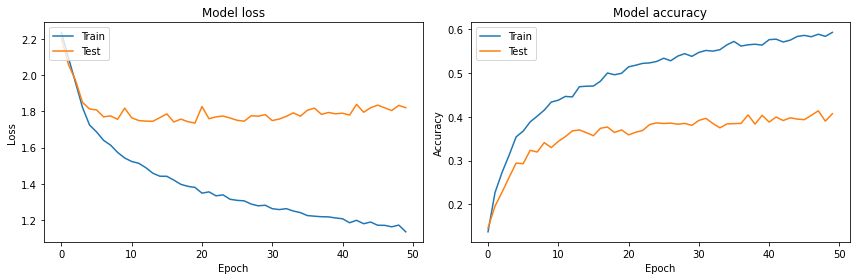

In [59]:
plt.figure(figsize=(12, 4))
metrics = history.history

plt.subplot(1, 2, 1)
plt.title('Model loss')
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left') 

plt.subplot(1, 2, 2)
plt.title('Model accuracy')
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
#plt.show()

### Confusion matrix

In [33]:
# Predict probabilities for test set
y_probs = model.predict(X_test)

In [34]:
# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test, axis=1)

In [35]:
# Add "pred" column
test_data['pred'] = yhat_probs

<ipython-input-35-c3152a5c3e3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred'] = yhat_probs


In [36]:
np.set_printoptions(precision=2)

In [37]:
# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)
print(cm)

[[ 76   5  32  35  63  70  75 123   0  21]
 [  5 148   0  11  13   8   2  10   1  23]
 [  2   0 284  37   9  11  49  51  47  10]
 [ 15   6 120 155  22  31  26  42  40  43]
 [ 30  11  14  30  93 100  25 175   7  15]
 [ 58  41   4   7  64 174  18 109   5   3]
 [  1   0   2   1   2   6 129  34   0   9]
 [ 31  13   1   1  82 138  44 139   0   3]
 [  0   4  87  49  23  32  10  14 129  45]
 [  8   7  71  67  15   2   3  23  52 252]]


In [38]:
# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.34      0.15      0.21       500
        Car Horn       0.63      0.67      0.65       221
Children Playing       0.46      0.57      0.51       500
        Dog bark       0.39      0.31      0.35       500
        Drilling       0.24      0.19      0.21       500
   Engine Idling       0.30      0.36      0.33       483
        Gun Shot       0.34      0.70      0.46       184
      Jackhammer       0.19      0.31      0.24       452
           Siren       0.46      0.33      0.38       393
    Street Music       0.59      0.50      0.55       500

        accuracy                           0.37      4233
       macro avg       0.40      0.41      0.39      4233
    weighted avg       0.39      0.37      0.37      4233



In [39]:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
 
    plt.figure(figsize=(16, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


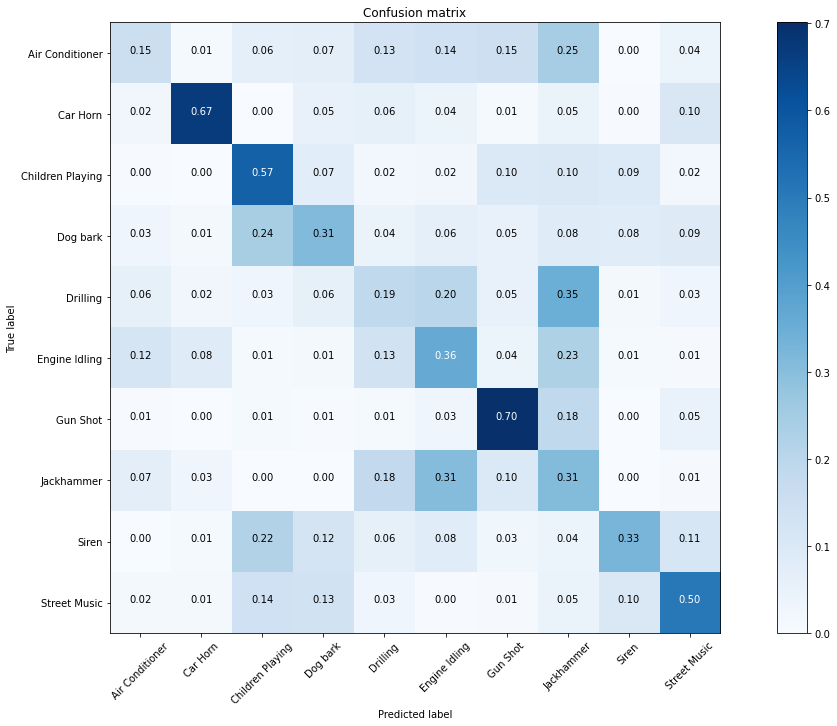

In [40]:
plot_confusion_matrix(cm,labels, normalize = True)

### Evaluate with cross validation


In [ ]:
# Extracting MFCC's and Chroma stft for every audio file
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name) 
    stft_features = librosa.feature.chroma_stft(y=audio, sr=sample_rate) #12 chroma 
    stft_scaled_features = np.mean(stft_features.T,axis=0) #temporal averaging
    
    return stft_scaled_features

In [ ]:
audio_dataset_path = 'C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio'

In [ ]:
features_stft = []

for index,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/'+str(row["slice_file_name"]))
    label_class = str(row["class"])
    data = features_extractor(file_name)
    features_stft.append([data,label_class])

In [ ]:
with open('features_stft.pkl', 'wb') as b:
    pickle.dump(features_stft,b)

In [ ]:
features_stft_df = pd.DataFrame(features_stft,columns=['Features','Class'])
features_stft_df.head()

In [ ]:
with open('features_stft_df.pkl', 'wb') as b:
    pickle.dump(features_stft_df,b)

In [41]:
#Read pkl file opinion_data
features_stft_df = pd.read_pickle("features_stft_df.pkl")

In [42]:
X = np.array(features_stft_df['Features'].tolist())
Y_labels = np.array(features_stft_df['Class'].tolist())

In [43]:
labelencoder = LabelEncoder()
Y = to_categorical(labelencoder.fit_transform(Y_labels))

In [44]:
def model_stft():
    
    model_stft = models.Sequential()
    model_stft.add(Dense(100, input_shape=(12,)))
    model_stft.add(Activation('relu'))
    model_stft.add(Dropout(0.2))

    model_stft.add(Dense(100, input_shape=(12,)))
    model_stft.add(Activation('relu'))
    model_stft.add(Dropout(0.2))
    
    model_stft.add(Dense(100, input_shape=(12,)))
    model_stft.add(Activation('relu'))
    model_stft.add(Dropout(0.2))

    model_stft.add(Dense(num_labels))
    model_stft.add(Activation('softmax'))

    model_stft.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model_stft

In [45]:
estimator = KerasClassifier(build_fn=model_stft, epochs=50, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 57.95% (2.12%)


### Testing new audio files

Here we will test the model with an audio file.

In [46]:
filename='C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio/fold8/103076-3-0-0.wav' #(dog)
audio, sample_rate = librosa.load(filename) 
stft_features = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
stft_scaled_features = np.mean(stft_features.T,axis=0)
print(stft_scaled_features)

[0.33 0.63 0.67 0.29 0.16 0.11 0.16 0.25 0.32 0.27 0.19 0.22]


In [47]:
stft_scaled_features=stft_scaled_features.reshape(1,-1)
print(stft_scaled_features.shape)

(1, 12)


In [48]:
predicted_label=model.predict(stft_scaled_features)
print(predicted_label)

[[2.58e-02 4.67e-03 3.92e-02 4.07e-01 1.21e-01 9.26e-03 2.24e-05 6.46e-04
  1.84e-01 2.09e-01]]


In [49]:
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
prediction_class

array(['dog_bark'], dtype='<U16')

In [50]:
ipd.Audio(filename) 

## Convolutional Neural Network - MFCC

### Model creation - Parameter tuning

In [ ]:
def padding(array, xx, yy):         """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [ ]:
dataset = []
labels=[]
max_size=174 #my max audio file feature width
directory ='C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio'
for index, row in tqdm(train_data.iterrows()):
    folder_num = row["fold"]
    file_name = row["slice_file_name"]
    label = row["class"]
    file_path = os.path.join(os.path.abspath(directory), "fold"+str(folder_num)+ "/", str(file_name) )
    audio, sampling_rate = librosa.load(file_path)
    mfcc=padding(librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=25),25, max_size)
    features=np.reshape(np.vstack((mfcc)),(25,174))
    dataset.append(features)
    labels.append(label)

In [ ]:
with open('dataset.pkl', 'wb') as b:
    pickle.dump(dataset,b)

In [ ]:
with open('labels.pkl', 'wb') as b:
    pickle.dump(labels,b)

In [6]:
with open('dataset.pkl', 'rb') as b:
    dataset=pickle.load(b)

In [7]:
with open('labels.pkl', 'rb') as b:
    labels=pickle.load(b) 

In [ ]:
dataset_test = []
labels_test=[] 
max_size=174
directory ='C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio'
for index, row in tqdm(test_data.iterrows()):
    folder_num = row["fold"]
    file_name = row["slice_file_name"]
    label = row["class"]
    file_path = os.path.join(os.path.abspath(directory), "fold"+str(folder_num)+ "/", str(file_name) )
    audio, sampling_rate = librosa.load(file_path)
    mfcc=padding(librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=25),25, max_size)
    features=np.reshape(np.vstack((mfcc)),(25,174))
    dataset_test.append(mfcc)
    labels_test.append(label)

In [ ]:
with open('dataset_test.pkl', 'wb') as b:
    pickle.dump(dataset_test,b)

In [ ]:
with open('labels_test.pkl', 'wb') as b:
    pickle.dump(labels_test,b)

In [8]:
with open('dataset_test.pkl', 'rb') as b:
    dataset_test=pickle.load(b) 

In [9]:
with open('labels_test.pkl', 'rb') as b:
    labels_test=pickle.load(b) 

In [10]:
x_train=np.array(dataset) #coverting the features vector to a numpy array
y_train = np.array(labels).tolist()
x_train=x_train.reshape(x_train.shape[0], 25, 174, 1) #reshaping the array for the convolution layer input

In [11]:
x_test=np.array(dataset_test) 
y_test = np.array(labels_test).tolist()
x_test=x_test.reshape(x_test.shape[0], 25, 174, 1)

In [12]:
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(labels))
y_test = to_categorical(le.fit_transform(labels_test))

In [13]:
x_train.shape,y_train.shape, x_test.shape, y_test.shape

((4499, 25, 174, 1), (4499, 10), (4233, 25, 174, 1), (4233, 10))

In [14]:
#Number of classes
num_labels=y_train.shape[1]
print(num_labels)

10


In [15]:
input_dim = (25, 174, 1)

In [16]:
#forming model
model=Sequential()

model.add(Conv2D(64,kernel_size=5,strides=2,padding="Same",activation="relu",input_shape=input_dim))
model.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model.add(Conv2D(128,kernel_size=3,strides=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model.add(Conv2D(256,kernel_size=3,strides=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model.add(Flatten()) #1 dimensional fully connected model

#First layer
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))

#Second layer
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.3))

#Last layer
model.add(Dense(num_labels,activation="softmax"))


In [17]:
#forming model
model2=Sequential()

model2.add(Conv2D(64,kernel_size=5,strides=2,padding="Same",activation="relu",input_shape=input_dim))
model2.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))
model2.add(Dropout(0.3))

model2.add(Conv2D(128,kernel_size=3,strides=2,padding="same",activation="relu"))
model2.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))
model2.add(Dropout(0.3))

model2.add(Conv2D(256,kernel_size=3,strides=2,padding="same",activation="relu"))
model2.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))
model2.add(Dropout(0.3))

model2.add(Flatten()) #1 dimensional fully connected model

#First layer
model2.add(Dense(128,activation="relu"))
model2.add(Dropout(0.3))

#Second layer
model2.add(Dense(64,activation="relu"))
model2.add(Dropout(0.3))

#Last layer
model2.add(Dense(num_labels,activation="softmax"))

In [18]:
#forming model
model3=Sequential()

model3.add(Conv2D(64,kernel_size=5,strides=2,padding="Same",activation="relu",input_shape=input_dim))
model3.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model3.add(Conv2D(128,kernel_size=3,strides=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model3.add(Conv2D(256,kernel_size=3,strides=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model3.add(Conv2D(512,kernel_size=3,strides=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model3.add(Flatten()) #1 dimensional fully connected model

#First layer
model3.add(Dense(128,activation="relu"))
model3.add(Dropout(0.3))

#Second layer
model3.add(Dense(64,activation="relu"))
model3.add(Dropout(0.3))

#Last layer
model3.add(Dense(num_labels,activation="softmax"))

In [19]:
#forming model
model4=Sequential()

model4.add(Conv2D(64,kernel_size=5,strides=2,padding="Same",activation="relu",input_shape=input_dim))
model4.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model4.add(Conv2D(128,kernel_size=3,strides=2,padding="same",activation="relu"))
model4.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model4.add(Flatten()) #1 dimensional fully connected model


#First layer
model4.add(Dense(64,activation="relu"))
model4.add(Dropout(0.3))

#Last layer
model4.add(Dense(num_labels,activation="softmax"))

In [20]:
#forming model
model5=Sequential()

model5.add(Conv2D(64,kernel_size=5,strides=2,padding="Same",activation="relu",input_shape=input_dim))
model5.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model5.add(Conv2D(128,kernel_size=3,strides=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model5.add(Conv2D(256,kernel_size=3,strides=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model5.add(Flatten()) #1 dimensional fully connected model

#First layer
model5.add(Dense(128,activation="relu"))
model5.add(Dropout(0.3))

#Second layer
model5.add(Dense(64,activation="relu"))
model5.add(Dropout(0.3))

#Last layer
model5.add(Dense(num_labels,activation="softmax"))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 87, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 44, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 22, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 11, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0

In [22]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 13, 87, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 44, 64)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 44, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 22, 128)        73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 11, 128)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 11, 128)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 6, 256)        

In [23]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 13, 87, 64)        1664      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 44, 64)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 22, 128)        73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 11, 128)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 3, 256)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 2, 512)        

In [24]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 13, 87, 64)        1664      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 44, 64)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 22, 128)        73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 2, 11, 128)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2816)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                180288    
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)               

In [25]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 13, 87, 64)        1664      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 44, 64)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 22, 128)        73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 2, 11, 128)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 3, 256)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 768)              

### Compiling the model

In [26]:
#compiling
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [27]:
#compiling
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [28]:
#compiling
model3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [29]:
#compiling
model4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [30]:
#compiling
model5.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

### Training the model

In [31]:
# fix random seed for reproducibility
seed = 34
np.random.seed(seed)

#training the model
num_epochs = 20 
num_batch_size = 50

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test))

Epoch 1/20
90/90 [==============================] - 41s 435ms/step - loss: 2.4342 - accuracy: 0.2105 - val_loss: 1.7750 - val_accuracy: 0.3747
Epoch 2/20
90/90 [==============================] - 41s 454ms/step - loss: 1.5477 - accuracy: 0.4638 - val_loss: 1.6289 - val_accuracy: 0.4590
Epoch 3/20
90/90 [==============================] - 38s 428ms/step - loss: 1.1405 - accuracy: 0.6047 - val_loss: 1.5590 - val_accuracy: 0.5089
Epoch 4/20
90/90 [==============================] - 39s 430ms/step - loss: 0.9438 - accuracy: 0.6914 - val_loss: 1.6297 - val_accuracy: 0.5001
Epoch 5/20
90/90 [==============================] - 38s 427ms/step - loss: 0.6967 - accuracy: 0.7734 - val_loss: 1.7114 - val_accuracy: 0.5162
Epoch 6/20
90/90 [==============================] - 39s 433ms/step - loss: 0.5993 - accuracy: 0.8142 - val_loss: 1.7648 - val_accuracy: 0.5785
Epoch 7/20
90/90 [==============================] - 39s 429ms/step - loss: 0.4245 - accuracy: 0.8594 - val_loss: 1.9807 - val_accuracy: 0.5800

In [32]:
# fix random seed for reproducibility
seed = 35
np.random.seed(seed)

num_epochs = 20 
num_batch_size = 50

history2 = model2.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test),callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/20
90/90 [==============================] - 45s 475ms/step - loss: 3.5508 - accuracy: 0.1314 - val_loss: 2.1481 - val_accuracy: 0.2039
Epoch 2/20
90/90 [==============================] - 42s 471ms/step - loss: 2.0871 - accuracy: 0.2157 - val_loss: 1.8580 - val_accuracy: 0.3697
Epoch 3/20
90/90 [==============================] - 42s 468ms/step - loss: 1.7573 - accuracy: 0.3477 - val_loss: 1.6502 - val_accuracy: 0.4382
Epoch 4/20
90/90 [==============================] - 43s 479ms/step - loss: 1.5651 - accuracy: 0.4462 - val_loss: 1.5168 - val_accuracy: 0.4949
Epoch 5/20
90/90 [==============================] - 43s 475ms/step - loss: 1.3455 - accuracy: 0.5206 - val_loss: 1.4889 - val_accuracy: 0.5228
Epoch 6/20
90/90 [==============================] - 45s 495ms/step - loss: 1.1549 - accuracy: 0.5943 - val_loss: 1.5140 - val_accuracy: 0.5183
Epoch 7/20
90/90 [==============================] - 42s 471ms/step - loss: 0.9600 - accuracy: 0.6722 - val_loss: 1.5987 - val_accuracy: 0.5030

In [33]:
# fix random seed for reproducibility
seed = 36
np.random.seed(seed)

#training the model
num_epochs = 20 
num_batch_size = 50

history3 = model3.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test))

Epoch 1/20
90/90 [==============================] - 75s 815ms/step - loss: 2.1810 - accuracy: 0.1973 - val_loss: 1.7442 - val_accuracy: 0.3827
Epoch 2/20
90/90 [==============================] - 73s 810ms/step - loss: 1.4051 - accuracy: 0.5104 - val_loss: 1.6714 - val_accuracy: 0.4640
Epoch 3/20
90/90 [==============================] - 73s 812ms/step - loss: 1.0363 - accuracy: 0.6517 - val_loss: 1.6568 - val_accuracy: 0.5320
Epoch 4/20
90/90 [==============================] - 72s 803ms/step - loss: 0.7895 - accuracy: 0.7493 - val_loss: 2.0501 - val_accuracy: 0.5438
Epoch 5/20
90/90 [==============================] - 73s 808ms/step - loss: 0.6323 - accuracy: 0.7962 - val_loss: 1.8487 - val_accuracy: 0.5374
Epoch 6/20
90/90 [==============================] - 72s 803ms/step - loss: 0.5471 - accuracy: 0.8372 - val_loss: 2.0680 - val_accuracy: 0.5185
Epoch 7/20
90/90 [==============================] - 78s 871ms/step - loss: 0.4308 - accuracy: 0.8680 - val_loss: 2.1616 - val_accuracy: 0.5571

In [34]:
# fix random seed for reproducibility
seed = 37
np.random.seed(seed)

#training the model
num_epochs = 20 
num_batch_size = 50

history4 = model4.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test))

Epoch 1/20
90/90 [==============================] - 24s 258ms/step - loss: 3.8913 - accuracy: 0.1905 - val_loss: 1.9027 - val_accuracy: 0.3314
Epoch 2/20
90/90 [==============================] - 28s 313ms/step - loss: 1.7706 - accuracy: 0.3657 - val_loss: 1.5934 - val_accuracy: 0.4408
Epoch 3/20
90/90 [==============================] - 28s 311ms/step - loss: 1.3768 - accuracy: 0.5165 - val_loss: 1.7045 - val_accuracy: 0.5013
Epoch 4/20
90/90 [==============================] - 28s 314ms/step - loss: 1.1292 - accuracy: 0.6104 - val_loss: 1.5766 - val_accuracy: 0.5273
Epoch 5/20
90/90 [==============================] - 28s 311ms/step - loss: 0.8833 - accuracy: 0.6825 - val_loss: 1.5381 - val_accuracy: 0.5273
Epoch 6/20
90/90 [==============================] - 28s 314ms/step - loss: 0.7355 - accuracy: 0.7458 - val_loss: 1.5997 - val_accuracy: 0.5738
Epoch 7/20
90/90 [==============================] - 29s 319ms/step - loss: 0.6014 - accuracy: 0.7928 - val_loss: 1.7766 - val_accuracy: 0.5478

In [35]:
# fix random seed for reproducibility
seed = 38
np.random.seed(seed)

#training the model
num_epochs = 10 
num_batch_size = 50

history5 = model5.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test))

Epoch 1/10
90/90 [==============================] - 40s 419ms/step - loss: 2.3260 - accuracy: 0.2224 - val_loss: 1.6715 - val_accuracy: 0.3978
Epoch 2/10
90/90 [==============================] - 37s 408ms/step - loss: 1.5200 - accuracy: 0.4725 - val_loss: 1.5858 - val_accuracy: 0.4567
Epoch 3/10
90/90 [==============================] - 37s 407ms/step - loss: 1.1970 - accuracy: 0.5896 - val_loss: 1.8026 - val_accuracy: 0.4942
Epoch 4/10
90/90 [==============================] - 37s 416ms/step - loss: 0.9246 - accuracy: 0.6951 - val_loss: 1.6191 - val_accuracy: 0.5346
Epoch 5/10
90/90 [==============================] - 37s 409ms/step - loss: 0.7113 - accuracy: 0.7647 - val_loss: 1.8387 - val_accuracy: 0.5263
Epoch 6/10
90/90 [==============================] - 37s 416ms/step - loss: 0.6046 - accuracy: 0.8051 - val_loss: 1.7985 - val_accuracy: 0.5537
Epoch 7/10
90/90 [==============================] - 37s 409ms/step - loss: 0.4882 - accuracy: 0.8428 - val_loss: 2.1840 - val_accuracy: 0.5672

In [36]:
model.save('C:/Users/USER/Downloads/model_mfcc') 
model = keras.models.load_model('C:/Users/USER/Downloads/model_mfcc')

INFO:tensorflow:Assets written to: C:/Users/USER/Downloads/model_mfcc\assets


In [37]:
model2.save('C:/Users/USER/Downloads/model2_mfcc')
model2 = keras.models.load_model('C:/Users/USER/Downloads/model2_mfcc')

INFO:tensorflow:Assets written to: C:/Users/USER/Downloads/model2_mfcc\assets


In [38]:
model3.save('C:/Users/USER/Downloads/model3_mfcc')
model3 = keras.models.load_model('C:/Users/USER/Downloads/model3_mfcc')

INFO:tensorflow:Assets written to: C:/Users/USER/Downloads/model3_mfcc\assets


In [39]:
model4.save('C:/Users/USER/Downloads/model4_mfcc')
model4 = keras.models.load_model('C:/Users/USER/Downloads/model4_mfcc')

INFO:tensorflow:Assets written to: C:/Users/USER/Downloads/model4_mfcc\assets


In [40]:
model5.save('C:/Users/USER/Downloads/model5_mfcc')
model5 = keras.models.load_model('C:/Users/USER/Downloads/model5_mfcc')

INFO:tensorflow:Assets written to: C:/Users/USER/Downloads/model5_mfcc\assets


In [41]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9377639293670654
Testing Accuracy:  0.526340663433075


In [42]:
# Evaluating the model on the training and testing set
score = model2.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model2.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9310957789421082
Testing Accuracy:  0.5875265598297119


In [43]:
# Evaluating the model on the training and testing set
score = model3.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model3.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9513224959373474
Testing Accuracy:  0.508386492729187


In [44]:
# Evaluating the model on the training and testing set
score = model4.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model4.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9773283004760742
Testing Accuracy:  0.5709898471832275


In [45]:
# Evaluating the model on the training and testing set
score = model5.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model5.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9611024856567383
Testing Accuracy:  0.5542168617248535


In [46]:
history = history5

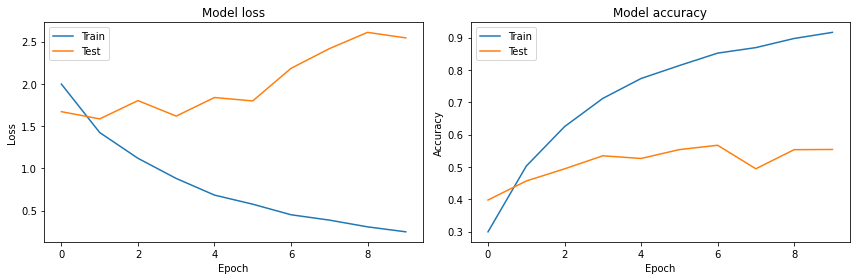

In [47]:
plt.figure(figsize=(12, 4))
metrics = history.history

plt.subplot(1, 2, 1)
plt.title('Model loss')
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left') 

plt.subplot(1, 2, 2)
plt.title('Model accuracy')
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.savefig('mfcc_model.png')

### Confusion matrix

In [48]:
# Predict probabilities for test set
y_probs = model5.predict(x_test)

In [49]:
# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test, axis=1)

In [50]:
# Add "pred" column
test_data['pred'] = yhat_probs

<ipython-input-50-c3152a5c3e3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred'] = yhat_probs


In [51]:
np.set_printoptions(precision=2)

In [52]:
# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)
print(cm)

[[156   1  51   0  44  93   0  68  14  73]
 [  1 165   5   3   3  17   0  16   0  11]
 [  7  10 344  10  26  18   0   1  16  68]
 [ 18  21  66 313  14   9  14   0  22  23]
 [ 12  30  16  22 218  32  11 109  23  27]
 [ 53  17  79   6  21 200   1  44  22  40]
 [  0   2   0   9   3   0 170   0   0   0]
 [ 65   4  11   0 171  12   3 170   0  16]
 [  3   6  26  17  14   8   0   1 300  18]
 [  7   4  79   7  27  14   1  13  38 310]]


In [53]:
# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.48      0.31      0.38       500
        Car Horn       0.63      0.75      0.69       221
Children Playing       0.51      0.69      0.58       500
        Dog bark       0.81      0.63      0.71       500
        Drilling       0.40      0.44      0.42       500
   Engine Idling       0.50      0.41      0.45       483
        Gun Shot       0.85      0.92      0.89       184
      Jackhammer       0.40      0.38      0.39       452
           Siren       0.69      0.76      0.72       393
    Street Music       0.53      0.62      0.57       500

        accuracy                           0.55      4233
       macro avg       0.58      0.59      0.58      4233
    weighted avg       0.56      0.55      0.55      4233



In [54]:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
 
    plt.figure(figsize=(16, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


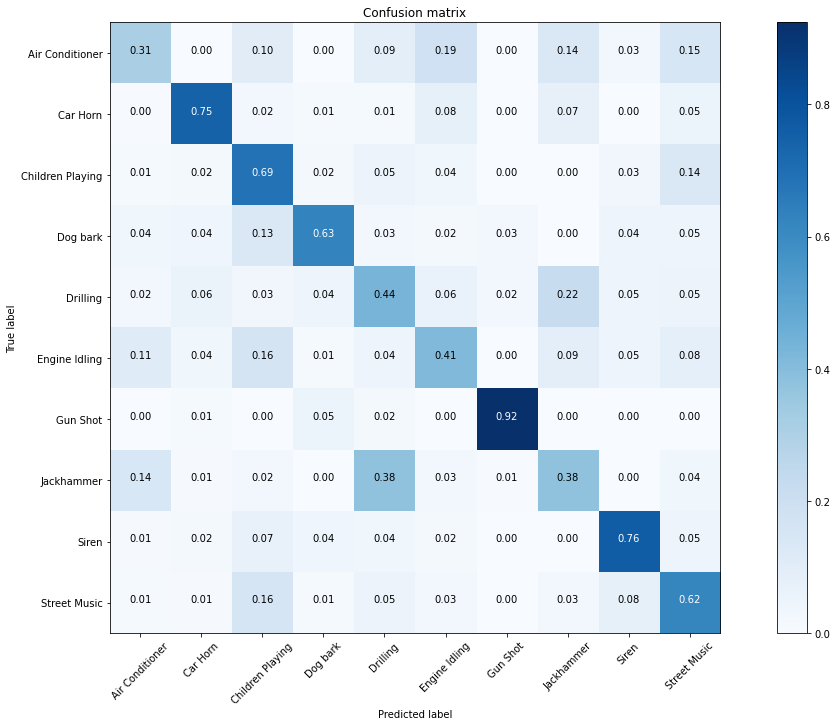

In [55]:
plot_confusion_matrix(cm,labels, normalize = True)

### Evaluate the model with CV

In [ ]:
dataset_cnn = []
max_size=174
directory ='C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio'
for index, row in tqdm(metadata.iterrows()):
    folder_num = row["fold"]
    file_name = row["slice_file_name"]
    label = row["class"]
    file_path = os.path.join(os.path.abspath(directory), "fold"+str(folder_num)+ "/", str(file_name) )
    audio, sampling_rate = librosa.load(file_path)
    mfcc=padding(librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=25),25, max_size)
    features=np.reshape(np.vstack((mfcc)),(25,174))
    dataset_cnn.append([mfcc, label])

In [ ]:
with open('dataset_cnn.pkl', 'wb') as b:
    pickle.dump(dataset_cnn,b)

In [ ]:
features_mfcc_cnn_df = pd.DataFrame(dataset_cnn,columns=['Features','Class'])
features_mfcc_cnn_df.head()

In [ ]:
with open('features_mfcc_cnn_df.pkl', 'wb') as b:
    pickle.dump(features_mfcc_cnn_df,b)

In [56]:
#Read pkl file opinion_data
features_mfcc_cnn_df = pd.read_pickle("features_mfcc_cnn_df.pkl")

In [57]:
X = np.array(features_mfcc_cnn_df['Features'].tolist())
X = X.reshape(X.shape[0], 25, 174, 1)
Y_labels = np.array(features_mfcc_cnn_df['Class'].tolist())
Y = to_categorical(le.fit_transform(Y_labels))

In [58]:
# fix random seed for reproducibility
seed = 678
np.random.seed(seed)

input_dim = (25, 174, 1)

def model_cnn_mfcc():
    
    model_cnn_mfcc=Sequential()

    model_cnn_mfcc.add(Conv2D(64,kernel_size=5,strides=2,padding="Same",activation="relu",input_shape=input_dim))
    model_cnn_mfcc.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))
    model_cnn_mfcc.add(Dropout(0.3))

    model_cnn_mfcc.add(Conv2D(128,kernel_size=3,strides=2,padding="same",activation="relu"))
    model_cnn_mfcc.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))
    model_cnn_mfcc.add(Dropout(0.3))

    model_cnn_mfcc.add(Conv2D(256,kernel_size=3,strides=2,padding="same",activation="relu"))
    model_cnn_mfcc.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))
    model_cnn_mfcc.add(Dropout(0.3))

    model_cnn_mfcc.add(Flatten()) #1 dimensional fully connected model

#First layer
    model_cnn_mfcc.add(Dense(128,activation="relu"))
    model_cnn_mfcc.add(Dropout(0.3))

#Second layer
    model_cnn_mfcc.add(Dense(64,activation="relu"))
    model_cnn_mfcc.add(Dropout(0.3))

#Last layer
    model_cnn_mfcc.add(Dense(num_labels,activation="softmax"))

    model_cnn_mfcc.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model_cnn_mfcc

In [ ]:
estimator = KerasClassifier(build_fn=model_cnn_mfcc, epochs=10, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

## Convolutional Neural Networks - CHROMA STFT

### Model creation - Parameter tuning

In [ ]:
dataset_stft = []
labels_stft=[]
max_size = 174
directory ='C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio'
for index, row in tqdm(train_data.iterrows()):
    folder_num = row["fold"]
    file_name = row["slice_file_name"]
    label = row["class"]
    file_path = os.path.join(os.path.abspath(directory), "fold"+str(folder_num)+ "/", str(file_name) )
    audio, sampling_rate = librosa.load(file_path)
    stft=padding(librosa.feature.chroma_stft(y=audio, sr=sampling_rate),12, max_size)
    features=np.reshape(np.vstack((stft)),(12,174))
    dataset_stft.append(features)
    labels_stft.append(label)

In [ ]:
with open('dataset_stft.pkl', 'wb') as b:
    pickle.dump(dataset_stft,b)

In [ ]:
with open('labels_stft.pkl', 'wb') as b:
    pickle.dump(labels_stft,b)

In [6]:
with open('dataset_stft.pkl', 'rb') as b:
    dataset_stft=pickle.load(b) 

In [7]:
with open('labels_stft.pkl', 'rb') as b:
    labels_stft=pickle.load(b) 

In [ ]:
dataset_stft_test = []
labels_stft_test=[]
max_size = 174
directory ='C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio'
for index, row in tqdm(test_data.iterrows()):
    folder_num = row["fold"]
    file_name = row["slice_file_name"]
    label = row["class"]
    file_path = os.path.join(os.path.abspath(directory), "fold"+str(folder_num)+ "/", str(file_name) )
    audio, sampling_rate = librosa.load(file_path)
    stft=padding(librosa.feature.chroma_stft(y=audio, sr=sampling_rate),12, max_size)
    features=np.reshape(np.vstack((stft)),(12,174))
    dataset_stft_test.append(features)
    labels_stft_test.append(label)

In [ ]:
with open('dataset_stft_test.pkl', 'wb') as b:
    pickle.dump(dataset_stft_test,b)

In [ ]:
with open('labels_stft_test.pkl', 'wb') as b:
    pickle.dump(labels_stft_test,b)

In [8]:
with open('dataset_stft_test.pkl', 'rb') as b:
    dataset_stft_test=pickle.load(b)

In [9]:
with open('labels_stft_test.pkl', 'rb') as b:
    labels_stft_test=pickle.load(b)

In [10]:
x_train=np.array(dataset_stft) #coverting the features vector to a numpy array
y_train = np.array(labels_stft).tolist()
x_train=x_train.reshape(x_train.shape[0], 12, 174, 1) #reshaping the array for the convolution layer input

In [11]:
x_test=np.array(dataset_stft_test) 
y_test = np.array(labels_stft_test).tolist()
x_test=x_test.reshape(x_test.shape[0], 12, 174, 1)

In [12]:
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(labels_stft))
y_test = to_categorical(le.fit_transform(labels_stft_test))

In [13]:
x_train.shape, x_test.shape

((4499, 12, 174, 1), (4233, 12, 174, 1))

In [14]:
y_train.shape, y_test.shape

((4499, 10), (4233, 10))

In [15]:
#Number of classes
num_labels=y_train.shape[1]
print(num_labels)

10


In [16]:
input_dim = (12, 174, 1)

In [17]:
#forming model
model=Sequential()

model.add(Conv2D(64,kernel_size=5,strides=2,padding="Same",activation="relu",input_shape=input_dim))
model.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model.add(Conv2D(128,kernel_size=3,strides=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model.add(Conv2D(256,kernel_size=3,strides=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model.add(Flatten()) #1 dimensional fully connected model

#First layer
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))

#Second layer
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.3))

#Last layer
model.add(Dense(num_labels,activation="softmax"))

In [18]:
#forming model
model2=Sequential()

model2.add(Conv2D(64,kernel_size=5,strides=2,padding="Same",activation="relu",input_shape=input_dim))
model2.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))
model2.add(Dropout(0.3))

model2.add(Conv2D(128,kernel_size=3,strides=2,padding="same",activation="relu"))
model2.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))
model2.add(Dropout(0.3))

model2.add(Conv2D(256,kernel_size=3,strides=2,padding="same",activation="relu"))
model2.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))
model2.add(Dropout(0.3))

model2.add(Flatten()) #1 dimensional fully connected model

#First layer
model2.add(Dense(128,activation="relu"))
model2.add(Dropout(0.3))

#Second layer
model2.add(Dense(64,activation="relu"))
model2.add(Dropout(0.3))

#Last layer
model2.add(Dense(num_labels,activation="softmax"))

In [19]:
#forming model
model3=Sequential()

model3.add(Conv2D(64,kernel_size=5,strides=2,padding="Same",activation="relu",input_shape=input_dim))
model3.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model3.add(Conv2D(128,kernel_size=3,strides=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model3.add(Conv2D(256,kernel_size=3,strides=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model3.add(Conv2D(512,kernel_size=3,strides=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model3.add(Flatten()) #1 dimensional fully connected model

#First layer
model3.add(Dense(128,activation="relu"))
model3.add(Dropout(0.3))

#Second layer
model3.add(Dense(64,activation="relu"))
model3.add(Dropout(0.3))

#Last layer
model3.add(Dense(num_labels,activation="softmax"))

In [20]:
#forming model
model4=Sequential()

model4.add(Conv2D(64,kernel_size=5,strides=2,padding="Same",activation="relu",input_shape=input_dim))
model4.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model4.add(Conv2D(128,kernel_size=3,strides=2,padding="same",activation="relu"))
model4.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model4.add(Flatten()) #1 dimensional fully connected model

#Second layer
model4.add(Dense(64,activation="relu"))
model4.add(Dropout(0.3))

#Last layer
model4.add(Dense(num_labels,activation="softmax"))

In [21]:
#forming model
model5=Sequential()

model5.add(Conv2D(64,kernel_size=5,strides=2,padding="Same",activation="relu",input_shape=input_dim))
model5.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model5.add(Conv2D(128,kernel_size=3,strides=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model5.add(Conv2D(256,kernel_size=3,strides=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

model5.add(Flatten()) #1 dimensional fully connected model

#First layer
model5.add(Dense(128,activation="relu"))
model5.add(Dropout(0.3))

#Second layer
model5.add(Dense(64,activation="relu"))
model5.add(Dropout(0.3))

#Last layer
model5.add(Dense(num_labels,activation="softmax"))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 87, 64)         1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 44, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 22, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 11, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0

In [23]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 6, 87, 64)         1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 44, 64)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 44, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 22, 128)        73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 11, 128)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 11, 128)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 6, 256)        

In [24]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 6, 87, 64)         1664      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 44, 64)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 22, 128)        73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 11, 128)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 3, 256)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 2, 512)        

In [25]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 6, 87, 64)         1664      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 44, 64)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 22, 128)        73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 11, 128)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                90176     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)               

In [26]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 6, 87, 64)         1664      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 3, 44, 64)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 2, 22, 128)        73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 11, 128)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 3, 256)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 768)              

### Compiling the model

In [27]:
#compiling
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [28]:
#compiling
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [29]:
#compiling
model3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [30]:
#compiling
model4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [31]:
#compiling
model5.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

### Training the model

In [32]:
# fix random seed for reproducibility
seed = 98
np.random.seed(seed)

#training the model
num_epochs = 20
num_batch_size = 50

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test))

Epoch 1/20
90/90 [==============================] - 33s 357ms/step - loss: 2.2362 - accuracy: 0.1425 - val_loss: 1.9735 - val_accuracy: 0.2228
Epoch 2/20
90/90 [==============================] - 32s 355ms/step - loss: 1.9009 - accuracy: 0.2638 - val_loss: 1.8464 - val_accuracy: 0.2821
Epoch 3/20
90/90 [==============================] - 33s 366ms/step - loss: 1.7734 - accuracy: 0.2948 - val_loss: 1.7913 - val_accuracy: 0.2936
Epoch 4/20
90/90 [==============================] - 30s 328ms/step - loss: 1.7199 - accuracy: 0.3175 - val_loss: 1.8395 - val_accuracy: 0.2936
Epoch 5/20
90/90 [==============================] - 36s 398ms/step - loss: 1.6369 - accuracy: 0.3413 - val_loss: 1.7736 - val_accuracy: 0.3092
Epoch 6/20
90/90 [==============================] - 28s 315ms/step - loss: 1.5552 - accuracy: 0.3794 - val_loss: 1.7612 - val_accuracy: 0.3274
Epoch 7/20
90/90 [==============================] - 28s 310ms/step - loss: 1.5196 - accuracy: 0.3993 - val_loss: 1.6940 - val_accuracy: 0.3508

In [33]:
# fix random seed for reproducibility
seed = 99
np.random.seed(seed)

#training the model
num_epochs = 20
num_batch_size = 50

history2 = model2.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test))

Epoch 1/20
90/90 [==============================] - 31s 319ms/step - loss: 2.2518 - accuracy: 0.1272 - val_loss: 2.0371 - val_accuracy: 0.2088
Epoch 2/20
90/90 [==============================] - 28s 307ms/step - loss: 1.9747 - accuracy: 0.2433 - val_loss: 1.8442 - val_accuracy: 0.2785
Epoch 3/20
90/90 [==============================] - 27s 304ms/step - loss: 1.7941 - accuracy: 0.2898 - val_loss: 1.8195 - val_accuracy: 0.2644
Epoch 4/20
90/90 [==============================] - 26s 294ms/step - loss: 1.7571 - accuracy: 0.3116 - val_loss: 1.7795 - val_accuracy: 0.2927
Epoch 5/20
90/90 [==============================] - 30s 334ms/step - loss: 1.6799 - accuracy: 0.3128 - val_loss: 1.8191 - val_accuracy: 0.2747
Epoch 6/20
90/90 [==============================] - 28s 311ms/step - loss: 1.6564 - accuracy: 0.3460 - val_loss: 1.7899 - val_accuracy: 0.2877
Epoch 7/20
90/90 [==============================] - 28s 312ms/step - loss: 1.5834 - accuracy: 0.3503 - val_loss: 1.6980 - val_accuracy: 0.3331

In [34]:
# fix random seed for reproducibility
seed = 100
np.random.seed(seed)

#training the model
num_epochs = 20
num_batch_size = 50

history3 = model3.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test))

Epoch 1/20
90/90 [==============================] - 60s 645ms/step - loss: 2.2360 - accuracy: 0.1258 - val_loss: 1.9312 - val_accuracy: 0.2214
Epoch 2/20
90/90 [==============================] - 58s 651ms/step - loss: 1.8953 - accuracy: 0.2695 - val_loss: 1.8073 - val_accuracy: 0.2688
Epoch 3/20
90/90 [==============================] - 57s 636ms/step - loss: 1.7712 - accuracy: 0.3033 - val_loss: 1.8010 - val_accuracy: 0.2653
Epoch 4/20
90/90 [==============================] - 61s 680ms/step - loss: 1.6818 - accuracy: 0.3261 - val_loss: 1.7930 - val_accuracy: 0.2927
Epoch 5/20
90/90 [==============================] - 63s 696ms/step - loss: 1.6120 - accuracy: 0.3461 - val_loss: 1.7483 - val_accuracy: 0.3442
Epoch 6/20
90/90 [==============================] - 63s 703ms/step - loss: 1.5258 - accuracy: 0.3852 - val_loss: 1.7080 - val_accuracy: 0.3177
Epoch 7/20
90/90 [==============================] - 59s 662ms/step - loss: 1.4604 - accuracy: 0.4080 - val_loss: 1.6777 - val_accuracy: 0.3704

In [35]:
# fix random seed for reproducibility
seed = 101
np.random.seed(seed)

#training the model
num_epochs = 20
num_batch_size = 50

history4 = model4.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test))

Epoch 1/20
90/90 [==============================] - 18s 185ms/step - loss: 2.1629 - accuracy: 0.1752 - val_loss: 1.9339 - val_accuracy: 0.2398
Epoch 2/20
90/90 [==============================] - 16s 180ms/step - loss: 1.8719 - accuracy: 0.2834 - val_loss: 1.8246 - val_accuracy: 0.2866
Epoch 3/20
90/90 [==============================] - 16s 181ms/step - loss: 1.7444 - accuracy: 0.3262 - val_loss: 1.7837 - val_accuracy: 0.3017
Epoch 4/20
90/90 [==============================] - 16s 181ms/step - loss: 1.6425 - accuracy: 0.3755 - val_loss: 1.8034 - val_accuracy: 0.3281
Epoch 5/20
90/90 [==============================] - 16s 183ms/step - loss: 1.5169 - accuracy: 0.4229 - val_loss: 1.7389 - val_accuracy: 0.3475
Epoch 6/20
90/90 [==============================] - 16s 182ms/step - loss: 1.4420 - accuracy: 0.4485 - val_loss: 1.7143 - val_accuracy: 0.3914
Epoch 7/20
90/90 [==============================] - 16s 184ms/step - loss: 1.3475 - accuracy: 0.4828 - val_loss: 1.6851 - val_accuracy: 0.4233

In [36]:
# fix random seed for reproducibility
seed = 102
np.random.seed(seed)

#training the model
num_epochs = 10
num_batch_size = 50

history5 = model5.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test))

Epoch 1/10
90/90 [==============================] - 27s 277ms/step - loss: 2.2099 - accuracy: 0.1460 - val_loss: 1.9640 - val_accuracy: 0.2277
Epoch 2/10
90/90 [==============================] - 25s 274ms/step - loss: 1.8619 - accuracy: 0.2689 - val_loss: 1.8036 - val_accuracy: 0.2776
Epoch 3/10
90/90 [==============================] - 24s 270ms/step - loss: 1.7112 - accuracy: 0.3082 - val_loss: 1.7618 - val_accuracy: 0.2977
Epoch 4/10
90/90 [==============================] - 24s 270ms/step - loss: 1.6383 - accuracy: 0.3383 - val_loss: 1.8567 - val_accuracy: 0.2939
Epoch 5/10
90/90 [==============================] - 24s 269ms/step - loss: 1.5448 - accuracy: 0.3770 - val_loss: 1.7339 - val_accuracy: 0.3185
Epoch 6/10
90/90 [==============================] - 24s 270ms/step - loss: 1.4762 - accuracy: 0.4209 - val_loss: 1.7640 - val_accuracy: 0.3586
Epoch 7/10
90/90 [==============================] - 24s 270ms/step - loss: 1.4354 - accuracy: 0.4304 - val_loss: 1.6695 - val_accuracy: 0.4023

In [ ]:
#model.save('C:/Users/USER/Downloads/model_stft')
model = keras.models.load_model('C:/Users/USER/Downloads/model_stft')

In [ ]:
model2.save('C:/Users/USER/Downloads/model2_stft')
model2 = keras.models.load_model('C:/Users/USER/Downloads/model2_stft')

In [ ]:
model3.save('C:/Users/USER/Downloads/model3_stft')
model3 = keras.models.load_model('C:/Users/USER/Downloads/model3_stft')

In [ ]:
model4.save('C:/Users/USER/Downloads/model4_stft')
model4 = keras.models.load_model('C:/Users/USER/Downloads/model4_stft')

In [ ]:
model5.save('C:/Users/USER/Downloads/model5_mfcc')
model5 = keras.models.load_model('C:/Users/USER/Downloads/model5_mfcc')

In [37]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8337408304214478
Testing Accuracy:  0.4738955795764923


In [38]:
# Evaluating the model on the training and testing set
score = model2.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model2.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.6997110247612
Testing Accuracy:  0.44601938128471375


In [39]:
# Evaluating the model on the training and testing set
score = model3.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model3.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8966436982154846
Testing Accuracy:  0.4318450391292572


In [40]:
# Evaluating the model on the training and testing set
score = model4.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model4.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8753056526184082
Testing Accuracy:  0.4625560939311981


In [41]:
# Evaluating the model on the training and testing set
score = model5.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model5.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.6308068633079529
Testing Accuracy:  0.4292463958263397


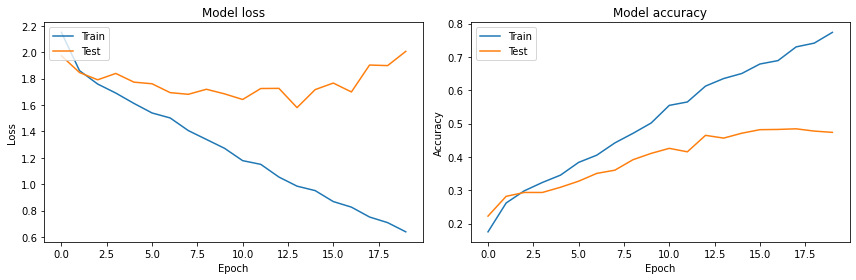

In [42]:
plt.figure(figsize=(12, 4))
metrics = history.history

plt.subplot(1, 2, 1)
plt.title('Model loss')
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left') 

plt.subplot(1, 2, 2)
plt.title('Model accuracy')
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.savefig('stft_model.png')

### Confusion Matrix



In [43]:
# Predict probabilities for test set
y_probs = model.predict(x_test)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test, axis=1)

In [44]:
# Add "pred" column
test_data['pred'] = yhat_probs


np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

<ipython-input-44-314262dfd874>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred'] = yhat_probs


In [45]:
# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.37      0.40      0.38       500
        Car Horn       0.69      0.54      0.61       221
Children Playing       0.42      0.59      0.49       500
        Dog bark       0.53      0.52      0.53       500
        Drilling       0.39      0.34      0.36       500
   Engine Idling       0.53      0.43      0.47       483
        Gun Shot       0.72      0.73      0.73       184
      Jackhammer       0.29      0.29      0.29       452
           Siren       0.63      0.51      0.56       393
    Street Music       0.53      0.59      0.56       500

        accuracy                           0.47      4233
       macro avg       0.51      0.49      0.50      4233
    weighted avg       0.48      0.47      0.47      4233



In [46]:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
 
    plt.figure(figsize=(16, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  

Normalized confusion matrix


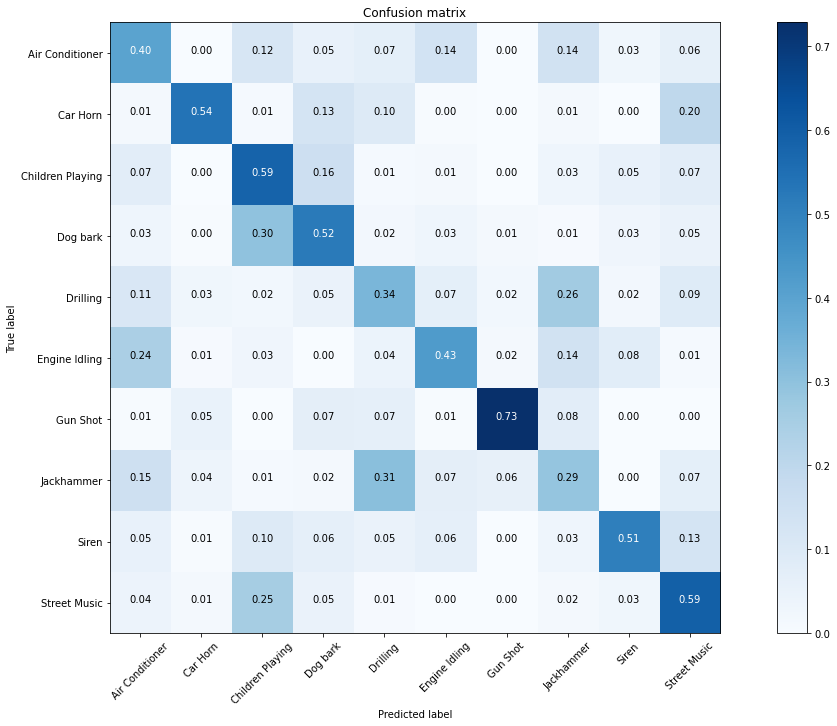

In [47]:
plot_confusion_matrix(cm,labels, normalize = True)

### Evaluate the model with CV

In [ ]:
dataset_stft_cnn = []
max_size = 174
directory ='C:/Users/USER/Downloads/UrbanSound8K/UrbanSound8K/audio'
for index, row in tqdm(metadata.iterrows()):
    folder_num = row["fold"]
    file_name = row["slice_file_name"]
    label = row["class"]
    file_path = os.path.join(os.path.abspath(directory), "fold"+str(folder_num)+ "/", str(file_name) )
    audio, sampling_rate = librosa.load(file_path)
    stft=padding(librosa.feature.chroma_stft(y=audio, sr=sampling_rate),12, max_size)
    features=np.reshape(np.vstack((stft)),(12,174))
    dataset_stft_cnn.append([features, label])

In [ ]:
with open('dataset_stft_cnn.pkl', 'wb') as b:
    pickle.dump(dataset_stft_cnn,b)

In [ ]:
features_stft_cnn_df = pd.DataFrame(dataset_stft_cnn,columns=['Features','Class'])
features_stft_cnn_df.head()

In [ ]:
with open('features_stft_cnn_df.pkl', 'wb') as b:
    pickle.dump(features_stft_cnn_df,b)

In [ ]:
#Read pkl file opinion_data
features_stft_cnn_df = pd.read_pickle("features_stft_cnn_df.pkl")

In [ ]:
X = np.array(features_stft_cnn_df['Features'].tolist())
X = X.reshape(X.shape[0],12, 174, 1)
Y_labels = np.array(features_stft_cnn_df['Class'].tolist())
Y = to_categorical(le.fit_transform(Y_labels))

In [ ]:
X = np.array((X-np.min(X))/(np.max(X)-np.min(X)))
X = X/np.std(X)
Y = np.array(Y)

In [ ]:
input_dim = (12, 174, 1)


def model_cnn_stft():
    
    model_cnn_stft=Sequential()

    model_cnn_stft.add(Conv2D(64,kernel_size=5,strides=2,padding="Same",activation="relu",input_shape=input_dim))
    model_cnn_stft.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

    model_cnn_stft.add(Conv2D(128,kernel_size=3,strides=2,padding="same",activation="relu"))
    model_cnn_stft.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

    model_cnn_stft.add(Conv2D(256,kernel_size=3,strides=2,padding="same",activation="relu"))
    model_cnn_stft.add(MaxPooling2D(pool_size = (2, 2),strides=2,padding="Same"))

    model_cnn_stft.add(Flatten()) #1 dimensional fully connected model

#First layer
    model_cnn_stft.add(Dense(128,activation="relu"))
    model_cnn_stft.add(Dropout(0.3))

#Second layer
    model_cnn_stft.add(Dense(64,activation="relu"))
    model_cnn_stft.add(Dropout(0.3))

#Last layer
    model_cnn_stft.add(Dense(num_labels,activation="softmax"))

    model_cnn_stft.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model_cnn_stft

In [ ]:
estimator = KerasClassifier(build_fn=model_cnn_stft, epochs=20, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))